# Analisi dati di allenamento Garmin

Disponendo di un ampio dataset con oltre 75.000 registrazioni provenienti da un dispositivo Garmin (Edge 820), relative ad allenamenti in bicicletta, l'obiettivo è sviluppare modelli predittivi basati su alcuni parametri (come la velocità, la pendenza, ecc.) per prevedere alcuni parametri di interesse.
- *Regressione*:
    - predire il battito cardiaco istantaneo (bpm)
    - predire la potenza istantanea (W)
- *Classificazione*:
    - classificare la zona di frequenza cardiaca
    - classificare la zona di potenza

## Raccolta dei dati
Poiché i dati non sono stati raccolti da siti noti come [UCI](https://archive.ics.uci.edu/), [Kaggle](https://www.kaggle.com/), ecc. bensì da allenamenti svolti personalmente da Riccardo Fiorani, è stato necessario estrarre i dati dai file *.fit* e *.tcx* messi a disposizione da Garmin e convertirli in *.csv* in modo da poterli analizzare con Python.
Per fare questo si è utilizzato il tool [Fit File Repair Tool](https://www.fitfilerepairtool.info/), che permette di convertire i file *.fit* in *.csv*.
Aggiungi ulteriore descrizione....

## Descrizione dei dati
Non essendo i dati provenienti da un dataset noto, è necessario descriverli in modo da poterli analizzare e comprendere meglio.
I *CSV* e i formati originali sono visionabili nella cartella del progetto `garmin_edge_820/`.
In particolare il dataset utilizzato è dato dall'unione di 4 allenamenti, ciascuno relativo a un allenamento.
Ogni record rappresenta un istante di un dato allenamento, raccolto con cadenza di un secondo, e contiene le seguenti informazioni:
- `timestamp`: data e ora dell'istante
- `distance`: distanza percorsa dall'inizio dell'allenamento (m)
- `accumulated_power`: potenza accumulata da inizio allenamento (W)
- `altitude`: altitudine (m)
- `speed`: velocità istantanea (m/s)
- `power`: potenza istantanea (W)
- `heart_rate`: frequenza cardiaca (bpm)
- `cadence`: cadenza di pedalata (rpm)
- `temperature`: temperatura (°C)
- `left_right_balance`: bilanciamento destro/sinistro, corrisponde alla percentuale di potenza applicata dal piede destro in rapporto a quella applicata dal piede sinistro. 
- `left_pco`: parametro Garmin che indica la distribuzione della forza lungo la battuta del pedale durante la pedalata. In questo caso relativo al piede sinistro. Il PCO si misura in millimetri. Valori positivi (ad es. +6 mm) indicano una forza maggiore verso l'esterno del pedale, mentre valori negativi (ad es. -4 mm) indicano una maggiore forza verso l'interno del pedale. Si veda la seguente immagine per ulteriori informazioni
<div align="center"><img src="imgs/pco.png" width="200"></div>

- `right_pco`: come sopra ma relativo al piede destro.
- `left_power_phase`: I sensori di potenza Garmin rilevano il punto in cui la gamba genera una coppia positiva in una pedalata e dove si verifica la maggiore concentrazione di coppia positiva. Inoltre, rilevano l'angolo a cui queste forze iniziano e terminano e il punto in cui si produce la concentrazione di potenza.
<div align="center"><img src="imgs/pwrphase.png" width="200"></div>

- `left_power_phase_peak`: picco massimo di power phase sinistra.
- `right_power_phase`: power phase destro.
- `right_power_phase_peak`: picco massimo di power phase destra.

A questi parametri sono stati aggiunti altri parametri derivati, come:
- `time_since_start`: tempo trascorso dall'inizio dell'allenamento (s). Volevamo verificare se vi è una correlazione fra tempo trascorso e frequenza cardiaca, potenza, ecc.
- `hr_zone`: zona di frequenza cardiaca. Per calcolarla abbiamo usato i seguenti intervalli suggeriti da Garmin 
    - Zona 1: (0, 128)
    - Zona 2: (129, 146)
    - Zona 3: (147, 156)
    - Zona 4: (157, 165)
    - Zona 5: (166, 174)
    - Zona 6: (175, 179)
    - Zona 7: $\geq$ 180
- `pwr_zone`: zona di potenza. Per calcolarla abbiamo usato i seguenti intervalli suggeriti da Garmin 
    - Zona 1: (0, 157)
    - Zona 2: (158, 186)
    - Zona 3: (187, 200)
    - Zona 4: (201, 218)
    - Zona 5: (219, 247)
    - Zona 6: (248, 287)
    - Zona 7: $\geq$ 288
- `altitude_diff`: differenza di altitudine rispetto al secondo precedente (m)
- `distance_diff`: differenza di distanza rispetto al secondo precedente (m)
- `slope_percent`: pendenza istantanea (%), calcolata come 
$$
\frac{\text{\texttt{altitude\_diff}}}{\text{\texttt{distance\_diff}}}
$$

In totale il dataset è composto da 65.344 record.

## Preparazione dei dati

Di seguito sono riportate le operazioni di preparazione dei dati effettuate prima di procedere con l'analisi vera e propria.

In [1]:
#%pip install numpy
#%pip install pandas
#%pip install matplotlib
#%pip install scikit-learn
#%pip install lightgbm
#%pip install xgboost
#%pip install flask

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
file_list = ["garmin_edge_820/3993730634_ACTIVITY_data.csv",
             "garmin_edge_820/4557226804_ACTIVITY_data.csv",
             "garmin_edge_820/4593452980_ACTIVITY_data.csv",
             "garmin_edge_820/5191513011_ACTIVITY_data.csv",
]
combined_df = pd.concat([pd.read_csv(file, sep=";") for file in file_list], ignore_index=True)

In [4]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65344 entries, 0 to 65343
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   timestamp[s]                     65344 non-null  int64  
 1   distance[m]                      65344 non-null  float64
 2   altitude[m]                      65344 non-null  float64
 3   speed[m/s]                       65332 non-null  float64
 4   power[watts]                     65344 non-null  int64  
 5   heart_rate[bpm]                  65344 non-null  int64  
 6   temperature[C]                   65344 non-null  int64  
 7   cadence[rpm]                     65344 non-null  int64  
 8   accumulated_power[watts]         65344 non-null  int64  
 9   left_pco[mm]                     65344 non-null  int64  
 10  right_pco[mm]                    65344 non-null  int64  
 11  right_power_phase[degrees]       65344 non-null  object 
 12  right_power_phase_

Poiché alcuni modelli (LGBM Regressor) non supportano features aventi caratteri non unicode, abbiamo sostituito le parentesi quadre con delle tonde usando il metodo `convert_brackets`

In [5]:
def convert_brackets(string):
    return string.replace('[', '(').replace(']', ')')

combined_df.columns = [convert_brackets(col) for col in combined_df.columns]

Di seguito è invece implementata una funzione che genera le zone di frequenza cardiaca e di potenza.

In [6]:
hr_zones = [(0, 128), (129, 146), (147, 156), (157, 165),(166, 174), (175, 179), (180, float('inf'))]
power_zones = [(0, 157), (158, 186), (187, 200), (201, 218),(219, 247), (248, 287), (288, float('inf'))]

def get_zone(rate, zones):
    for zone, (lower, upper) in enumerate(zones, start=1):
        if lower <= rate <= upper:
            return zone
        
combined_df['hr_zone'] = combined_df['heart_rate(bpm)'].apply(get_zone, zones=hr_zones)
combined_df['pwr_zone'] = combined_df['power(watts)'].apply(get_zone, zones=power_zones)

A questo punto si calcolano le features relative alla differenza di altitudine e distanza dall'istante successivo. Successivamente vengono utilizzate per calcolare la pendenza istantanea e anche quella media calcolata su una finestra di 20 secondi.

In [7]:
window_size = 20 
combined_df['altitude_diff(m)'] = combined_df['altitude(m)'] - combined_df['altitude(m)'].shift(1)
combined_df['distance_diff(m)'] = combined_df['distance(m)'] - combined_df['distance(m)'].shift(1)
combined_df[['altitude_diff(m)', 'distance_diff(m)']] = combined_df[['altitude_diff(m)', 'distance_diff(m)']].fillna(0)
combined_df['slope_percent'] = np.where(combined_df['distance_diff(m)'] == 0, 0, combined_df['altitude_diff(m)'] / combined_df['distance_diff(m)'] * 100)
combined_df['avg_slope_percent'] = combined_df['slope_percent'].rolling(window=int(window_size), center=True).mean()
combined_df = combined_df.dropna(subset=['avg_slope_percent'])

Di seguito sono riportati degli istogrammi che rappresentano la distribuzione dei valori assunti da battito e da potenza. I grafici indicano anche degli outliers che abbiamo stabilito essere

- 80 BPM nel caso del battito cardiaco. Questo perché in un allenamento in bici è estremamente difficile mantenere battito più basso. La campana di Gauss conferma la nostra ipotesi.
- 600 W per la potenza. In questo caso abbiamo ipotizzato che valori maggiori fossero dovuti a errori di misurazione.

In seguito toglieremo le istanze considerate appunto outliers.

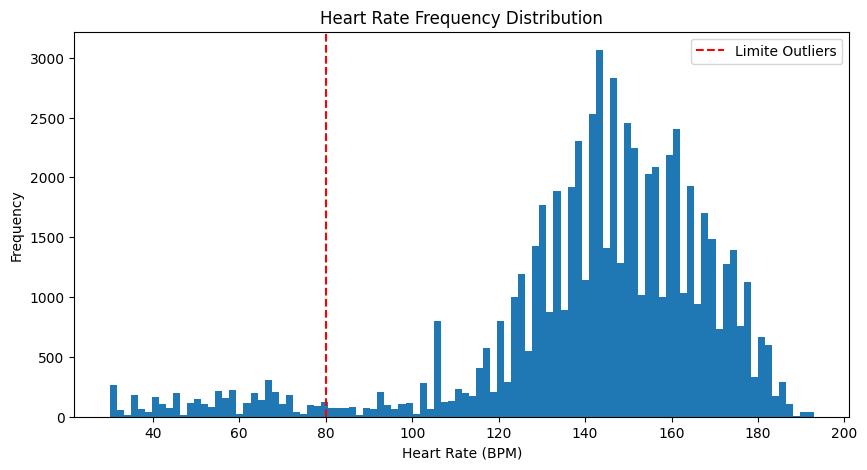

In [8]:
plt.figure(figsize=(10, 5))

plt.hist(combined_df['heart_rate(bpm)'], bins=100)

plt.title("Heart Rate Frequency Distribution")
plt.ylabel("Frequency")
plt.xlabel("Heart Rate (BPM)")

plt.axvline(x=80, color='red', linestyle='--', label='Limite Outliers')  
plt.legend()

plt.show()

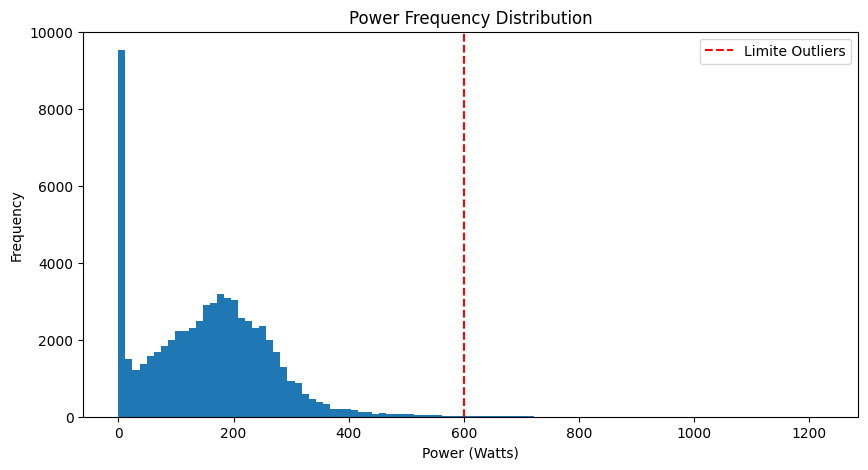

In [9]:
plt.figure(figsize=(10, 5))

plt.hist(combined_df['power(watts)'], bins=100)

plt.title("Power Frequency Distribution")
plt.ylabel("Frequency")
plt.xlabel("Power (Watts)")

plt.axvline(x=600, color='red', linestyle='--', label='Limite Outliers') 
plt.legend()

plt.show()

Qui invece viene definita una funzione che consente di plottare, per ogni allenamento, una determinata feature in funzione del tempo trascorso da inizio allenamento.

In [10]:
def plot_data_vs_time(col):
    df = combined_df.copy()
    df['timestamp(s)'] = df['timestamp(s)'] + 631065600
    df['time'] = pd.to_datetime(df.pop('timestamp(s)'), unit='s')
    df.set_index("time", inplace=True)
    df['time_since_start(s)'] = df.groupby(pd.Grouper(freq='D')).cumcount() + 1
    grouped_df = df.groupby(df.index.date)
    fig, ax = plt.subplots(nrows=len(grouped_df), sharex=True, figsize=(24, 9))
    for i, (date, data) in enumerate(grouped_df):
        ax[i].plot(data["time_since_start(s)"], data[col], label=str(date))

    fig.legend()

    fig.text(0.5, 0.04, "Time since Start", ha="center")
    fig.text(0.04, 0.5, col, va="center", rotation="vertical")
    plt.suptitle(f"{col} vs Time since Start for Each Training Day")

    plt.show()

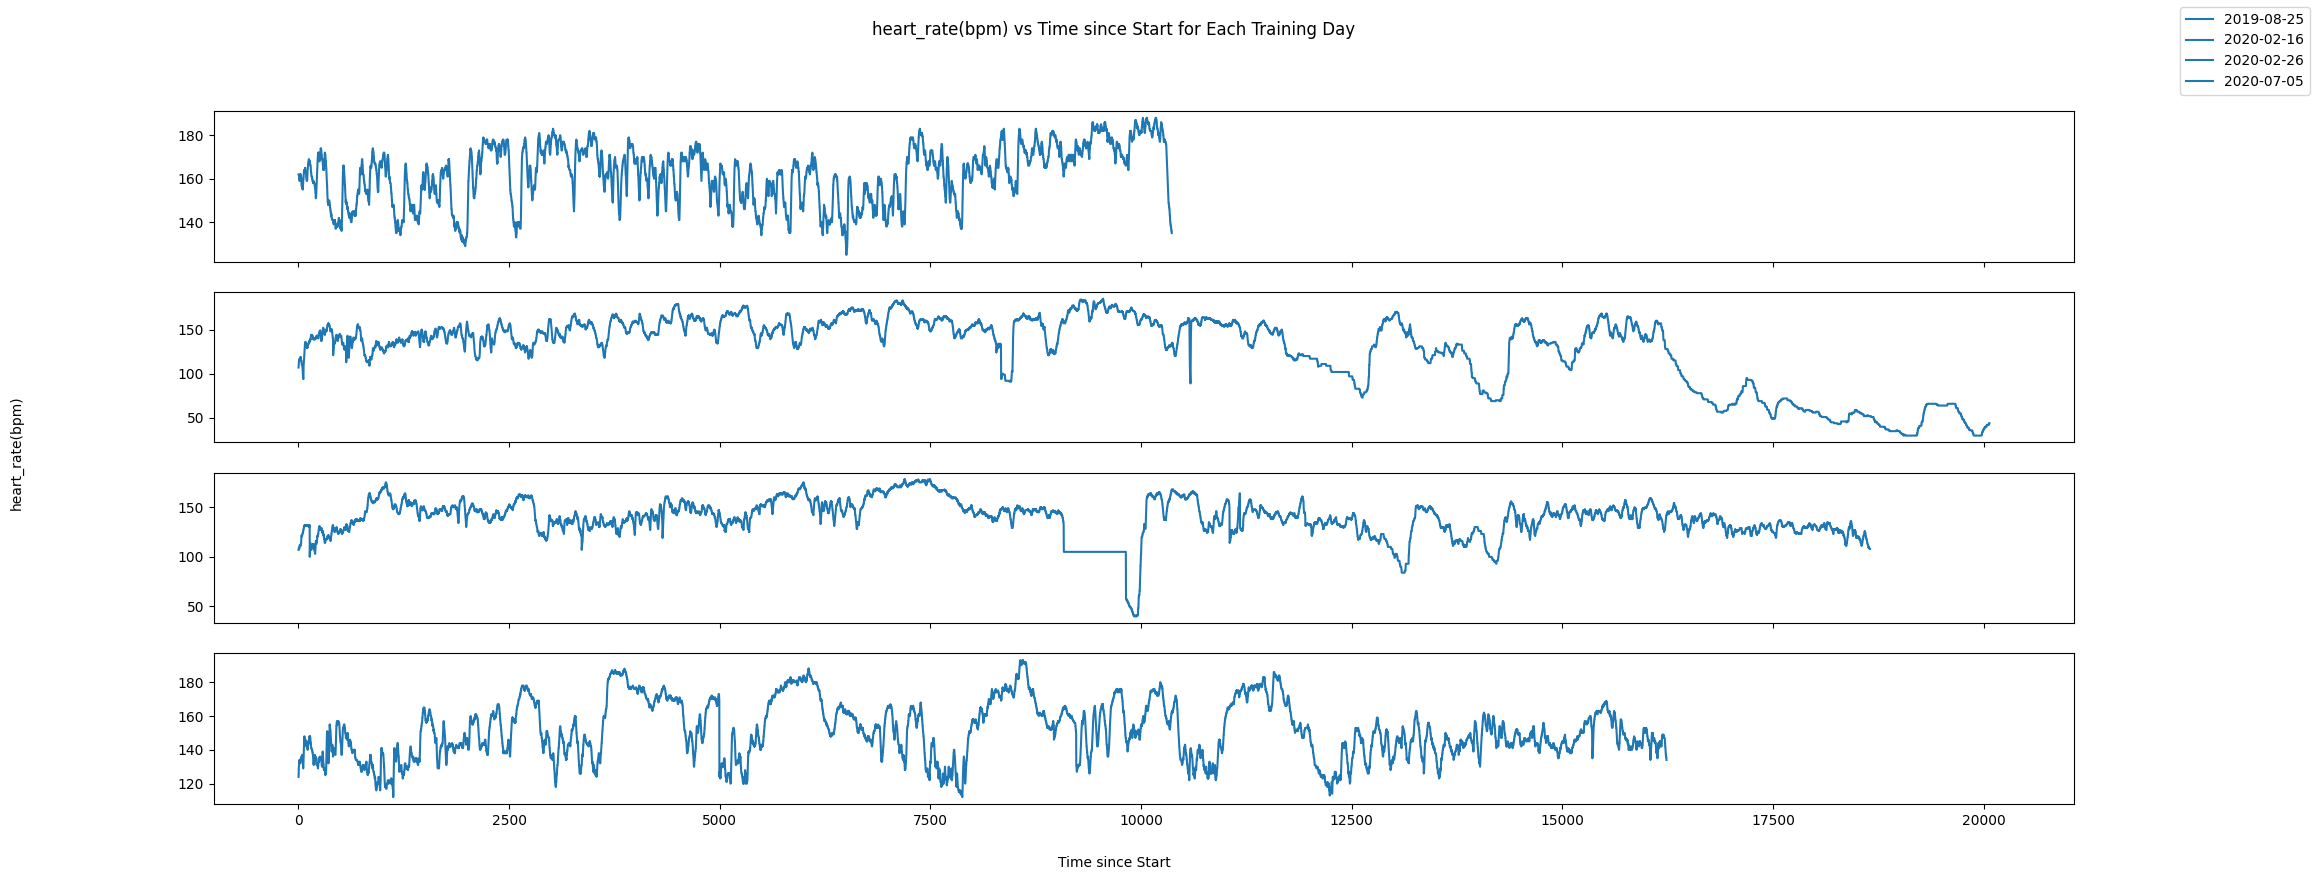

In [11]:
plot_data_vs_time('heart_rate(bpm)')

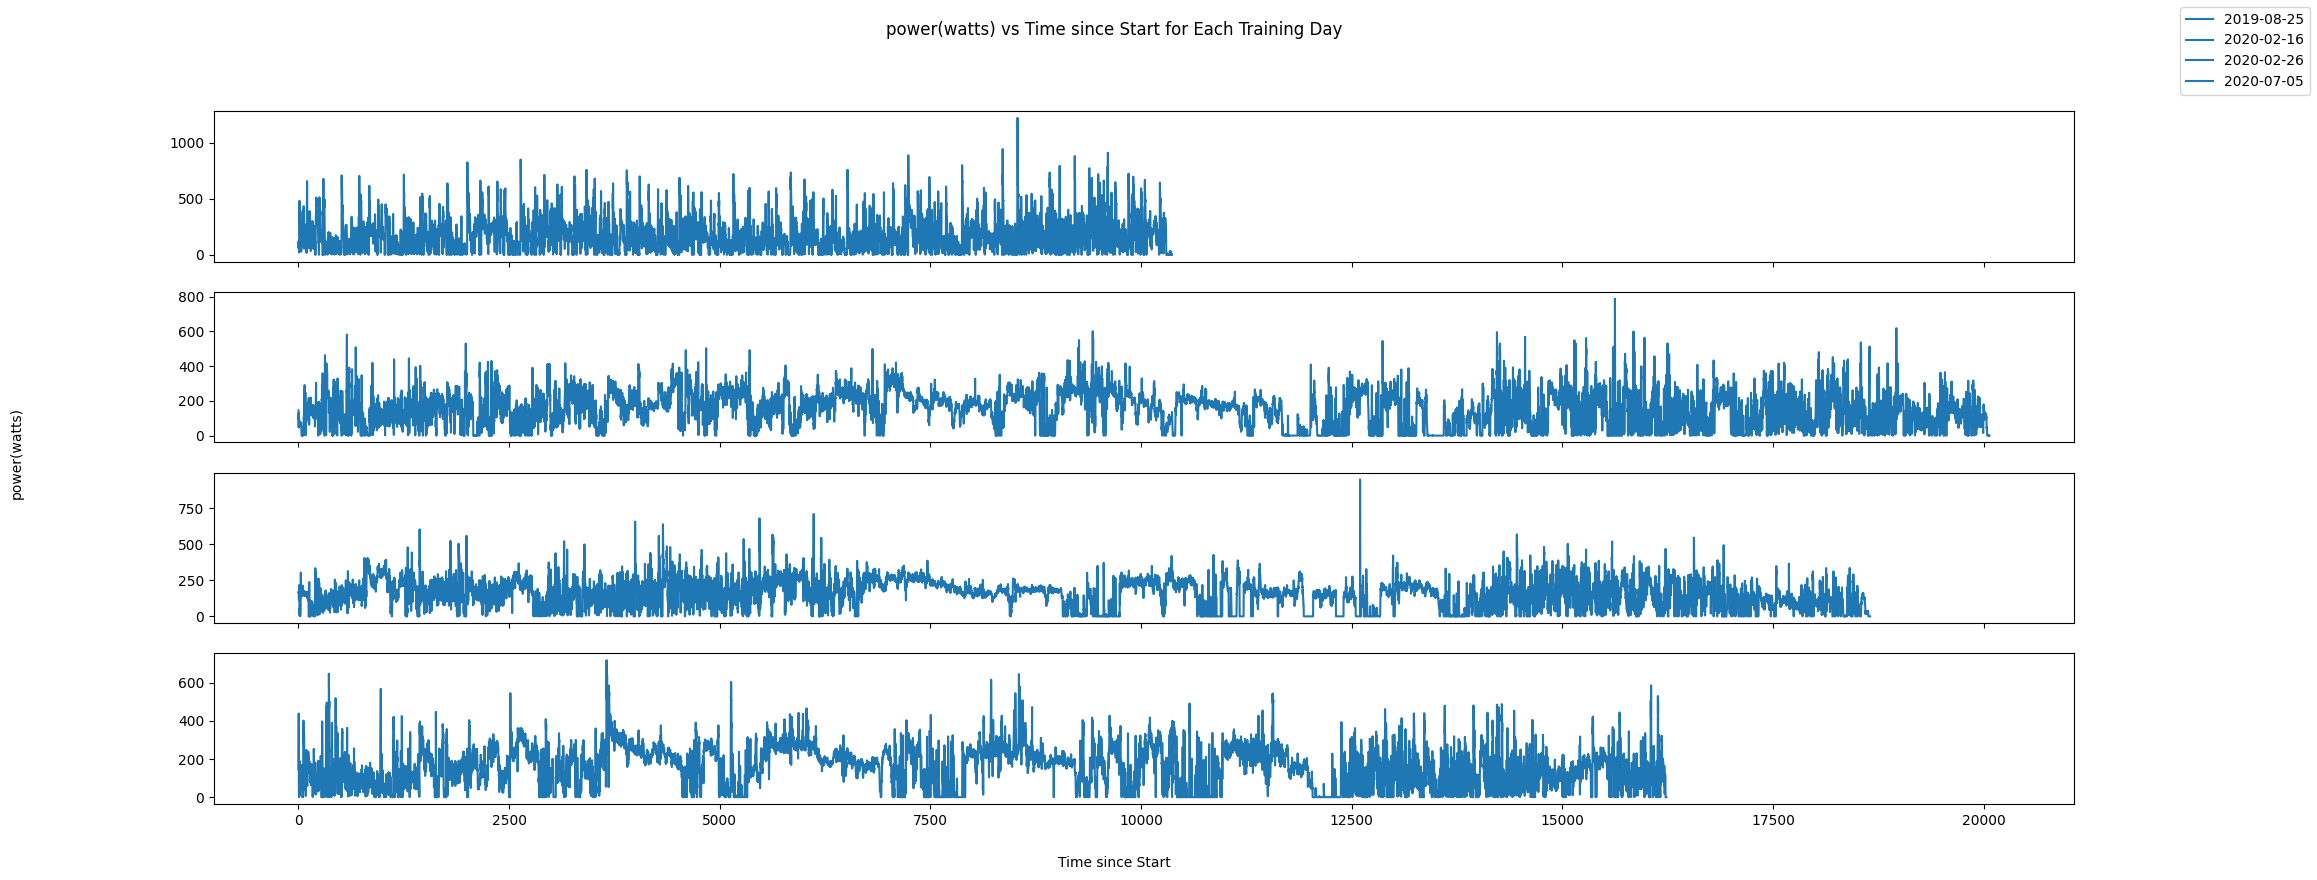

In [12]:
plot_data_vs_time('power(watts)')

La potenza, come mostrato nel grafico precedente, presenta valori molto instabili. In particolare si notano
- molti buchi, cioè linee rette nel grafico, che indicano che il sensore non ha rilevato la potenza
- picchi molto alti susseguiti da picchi molto bassi. Questo è dovuto al fatto che il sensore di potenza è molto sensibile e rileva anche piccole variazioni di potenza.

Per questo motivo abbiamo deciso di calcolare la media mobile con finestra di 3 secondi. Questo ci permette di avere una visione più chiara della potenza durante l'allenamento.

In [13]:
window_size = 6
combined_df['avg_power(watts)'] = combined_df['power(watts)'].rolling(window=int(window_size), center=True).mean()
combined_df = combined_df.dropna(subset=['avg_power(watts)'])
combined_df['avg_power(watts)'] = combined_df['avg_power(watts)'].astype('int64')
combined_df = combined_df[combined_df['avg_power(watts)'] > 0]

Il parametro `left_right_balance` di Garmin va trattato per visualizzare l'effettiva potenza di spinta da gamba sinistra e destra. In particolare Garmin suggerisce di usare la seguente formula
$$
\text{\texttt{left\_power}} = \text{\texttt{left\_right\_balance}} - 128 \\
\text{\texttt{right\_power}} = 100 - \text{\texttt{left\_power}}
$$


In [14]:
combined_df['power_left(watts)'] = combined_df['left_right_balance'] - 128
combined_df['power_right(watts)'] = 100 - combined_df['power_left(watts)']

Per questioni di errore di misurazione, abbiamo visto che alcuni record presentano valori di `speed(m/s)`, `power(watts)`, e di `cadence(rpm)` uguali a 0. Non essendo quei record rilevanti per l'analisi, abbiamo deciso di eliminarli. Inoltre, come mostrato nel `combined_df.info()` superiore, esistono molti valori di `speed(m/s)` posti a `NaN`. Abbiamo deciso di eliminare anche questi record.

La misurazione del battito cardiaco è molto imprecisa su valori bassi. Poiché è altamente iprobabile aver raggiunto 30 bpm durante un allenamento, abbiamo deciso di eliminare i record con frequenza cardiaca inferiore ad una soglia che, visionando il grafico precedente, abbiamo deciso di porre a 80bpm.

Per quanto riguarda la previsione della potenza, essendo molto lontani dalla frequenza media di tutti gli allenamenti, sono stati scartati i valori oltre ai 600 watts.

In [15]:
combined_df = combined_df[combined_df['speed(m/s)'] > 0]
combined_df = combined_df[(combined_df['power(watts)'] > 0) & (combined_df['power(watts)'] < 600)]
combined_df = combined_df[combined_df['cadence(rpm)'] > 0]
combined_df = combined_df[combined_df['heart_rate(bpm)'] > 80]
combined_df = combined_df.dropna(subset=['speed(m/s)'])

Dopo aver apportato queste modifiche al dataset, battito e potenza avranno il seguente aspetto

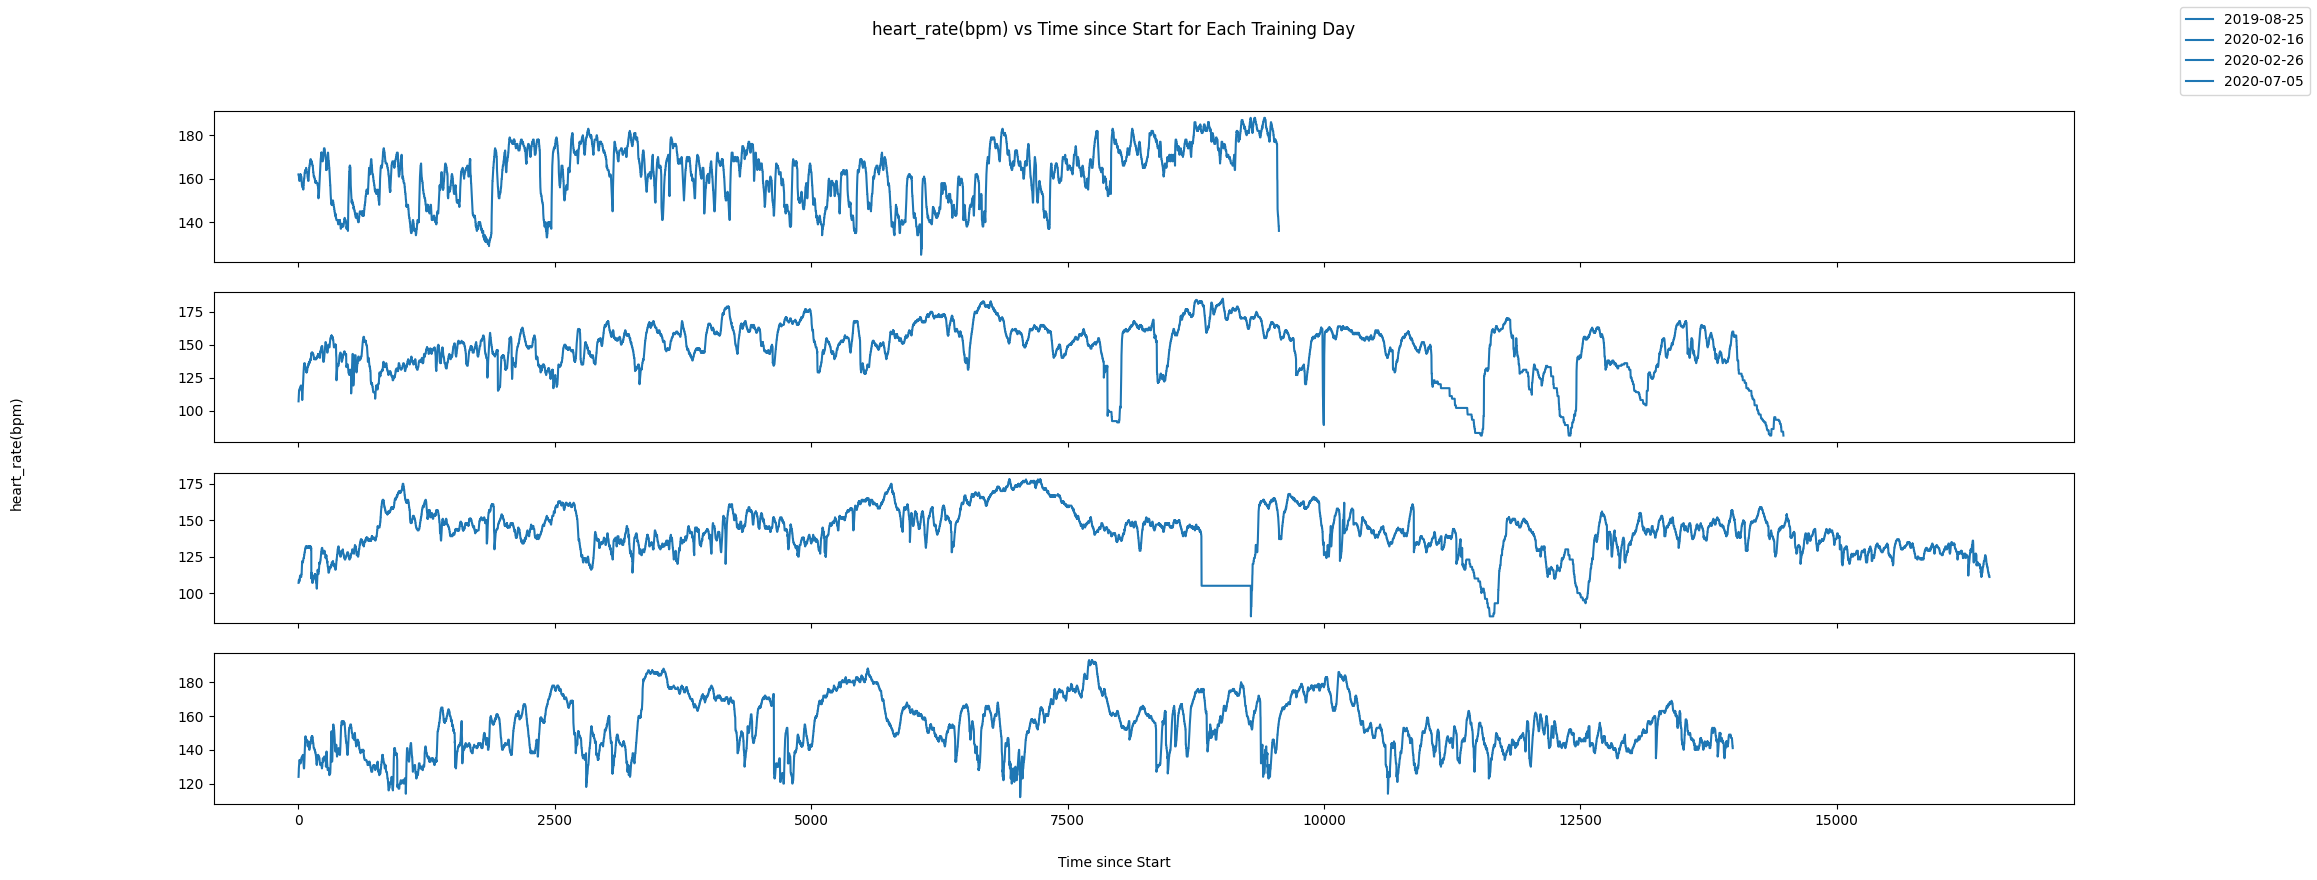

In [16]:
plot_data_vs_time('heart_rate(bpm)')

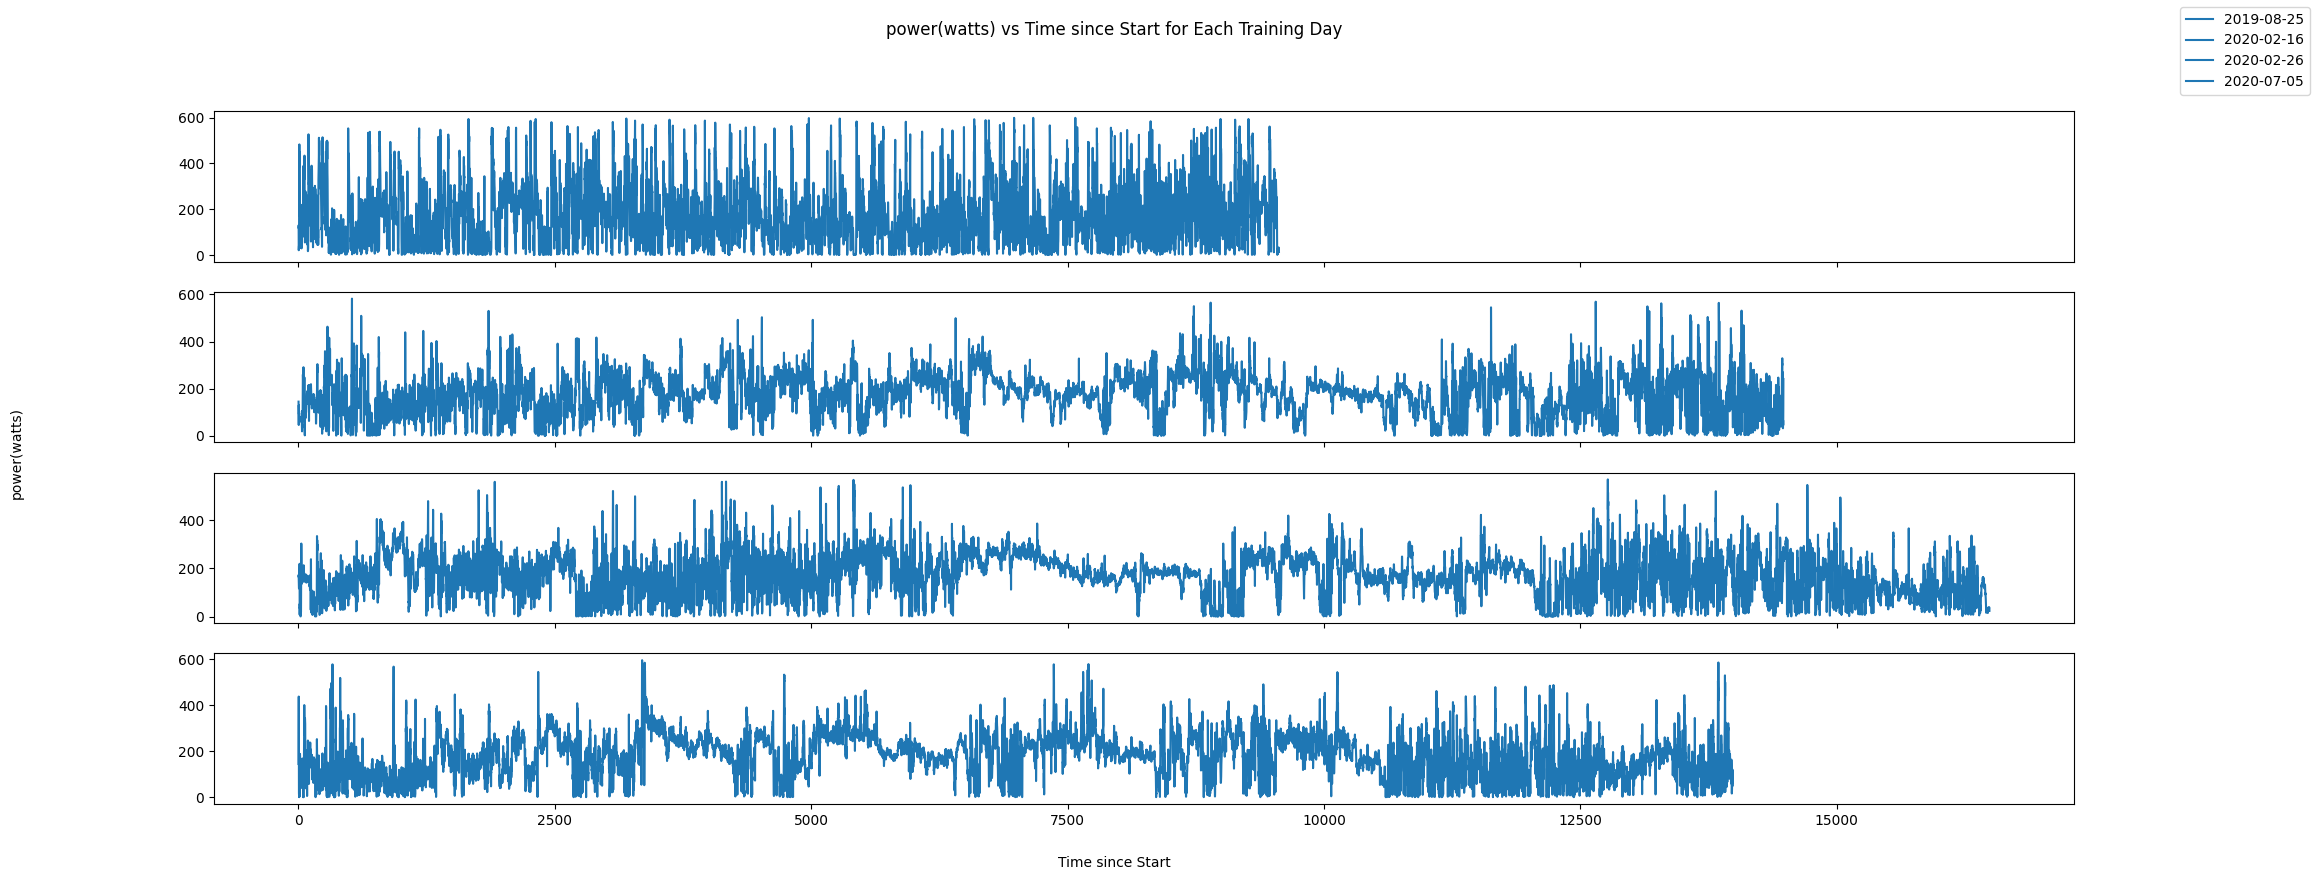

In [17]:
plot_data_vs_time('power(watts)')

A questo punto abbiamo deciso di sostituire la colonna `timestamp(s)` in un formato più comodo da gestire, ovvero `datetime`. Per fare questo abbiamo usato il metodo Pandas `to_datetime`. A questo punto abbiamo reso la colonna risultante `time` l'indice del DataFrame.

In [18]:
combined_df['timestamp(s)'] = combined_df['timestamp(s)'] + 631065600
combined_df['time'] = pd.to_datetime(combined_df.pop('timestamp(s)'), unit='s')
combined_df.set_index("time", inplace=True)

Come anticipato nella sezione precedente, abbiamo aggiunto una feature `time_since_start(s)` che indica il tempo trascorso dall'inizio dell'allenamento. 

In [19]:
combined_df['time_since_start(s)'] = combined_df.groupby(pd.Grouper(freq='D')).cumcount() + 1

Come ultima cosa vengono rimosse quelle feature inutilizzate per l'analisi.
- `left_right_balance`: non è più necessaria poiché abbiamo calcolato `left_power` e `right_power`
- `left_power_phase_peak`: non è necessario il picco se abbiamo il valore istantaneo
- `right_power_phase_peak`: come sopra
- `left_power_phase`: non neccessario per le nostre analisi
- `right_power_phase`: come sopra

In [20]:
combined_df = combined_df.drop(['left_power_phase(degrees)',
                            'left_power_phase_peak(degrees)',
                            'right_power_phase(degrees)',
                            'right_power_phase_peak(degrees)',
                            'left_right_balance'], axis=1)

In [21]:
combined_df.describe()

distance(m)   altitude(m)    speed(m/s)  power(watts)  \
count   54512.000000  54512.000000  54512.000000  54512.000000   
mean    64518.055661    252.015864      8.527000    174.317838   
std     37975.771366    264.892011      3.381381     97.467985   
min         6.790000      3.200000      0.370000      1.000000   
25%     33461.850000     57.000000      5.740000    105.000000   
50%     63888.325000    119.000000      9.070000    174.000000   
75%     91780.045000    407.400000     10.980000    236.000000   
max    151811.360000   1112.800000     18.140000    599.000000   

       heart_rate(bpm)  temperature(C)  cadence(rpm)  \
count     54512.000000    54512.000000  54512.000000   
mean        149.598327       19.842016     85.459202   
std          18.644274        8.142159     16.546028   
min          81.000000        5.000000      4.000000   
25%         139.000000       14.000000     81.000000   
50%         150.000000       16.000000     89.000000   
75%         163.000000       30.000000     95.000000   
max         193.000000       34.000000    142.000000   

       accumulated_power(watts)  left_pco(mm)  right_pco(mm)       hr_zone  \
count              5.451200e+04  54512.000000   54512.000000  54512.000000   
mean               1.270868e+06     -4.065197      -0.948690      3.169632   
std                7.955252e+05      5.977311       4.166878      1.548198   
min                3.340000e+02   -123.000000     -98.000000      1.000000   
25%                5.716995e+05     -7.000000      -3.000000      2.000000   
50%                1.232493e+06     -5.000000      -1.000000      3.000000   
75%                1.954320e+06     -2.000000       1.000000      4.000000   
max                2.871844e+06    123.000000     126.000000      7.000000   

           pwr_zone  altitude_diff(m)  distance_diff(m)  slope_percent  \
count  54512.000000      54512.000000      54512.000000   54512.000000   
mean       3.022362          0.047388          0.438200       1.805262   
std        2.222633          0.336620       1104.403416       4.584836   
min        1.000000        -42.600000    -170016.390000     -33.519553   
25%        1.000000          0.000000          5.740000       0.000000   
50%        2.000000          0.000000          9.070000       0.000000   
75%        5.000000          0.200000         11.002500       3.338898   
max        7.000000          4.600000        197.880000      55.555556   

       avg_slope_percent  avg_power(watts)  power_left(watts)  \
count       54512.000000      54512.000000       54512.000000   
mean            1.797368        172.746863          50.365938   
std             3.848807         86.246240          11.519313   
min           -22.589003          1.000000           0.000000   
25%            -0.338586        111.000000          48.000000   
50%             0.440151        172.000000          50.000000   
75%             3.892579        229.000000          53.000000   
max            28.007829        687.000000         100.000000   

       power_right(watts)  time_since_start(s)  
count        54512.000000         54512.000000  
mean            49.634062          7049.126082  
std             11.519313          4284.283055  
min              0.000000             1.000000  
25%             47.000000          3407.750000  
50%             50.000000          6814.500000  
75%             52.000000         10442.000000  
max            100.000000         16488.000000

In [23]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54512 entries, 2019-08-25 12:05:20 to 2020-07-05 10:23:31
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   distance(m)               54512 non-null  float64
 1   altitude(m)               54512 non-null  float64
 2   speed(m/s)                54512 non-null  float64
 3   power(watts)              54512 non-null  int64  
 4   heart_rate(bpm)           54512 non-null  int64  
 5   temperature(C)            54512 non-null  int64  
 6   cadence(rpm)              54512 non-null  int64  
 7   accumulated_power(watts)  54512 non-null  int64  
 8   left_pco(mm)              54512 non-null  int64  
 9   right_pco(mm)             54512 non-null  int64  
 10  hr_zone                   54512 non-null  int64  
 11  pwr_zone                  54512 non-null  int64  
 12  altitude_diff(m)          54512 non-null  float64
 13  distance_diff(m)          

# Data Visualization

Di seguito sono riportati i grafici che mostrano la distribuzione delle features. Per avere una visione più chiara si è deciso di dividere le misurazioni in base all'allenamento.

In [24]:
def plot_params_per_training(params):
    grouped_df = combined_df.groupby(combined_df.index.date)

    fig, axs = plt.subplots(nrows=len(grouped_df), figsize=(21, 10), sharex=True)

    for i, (date, data) in enumerate(grouped_df):
        axs[i].set_title(str(date))

        for param in params:
            axs[i].plot(data["time_since_start(s)"], data[param], label=param)

        axs[i].legend()
        axs[i].grid(True)

    plt.xlabel("time_since_start")
    plt.suptitle("Data vs Time since Start for Each Training Day")
    plt.show()

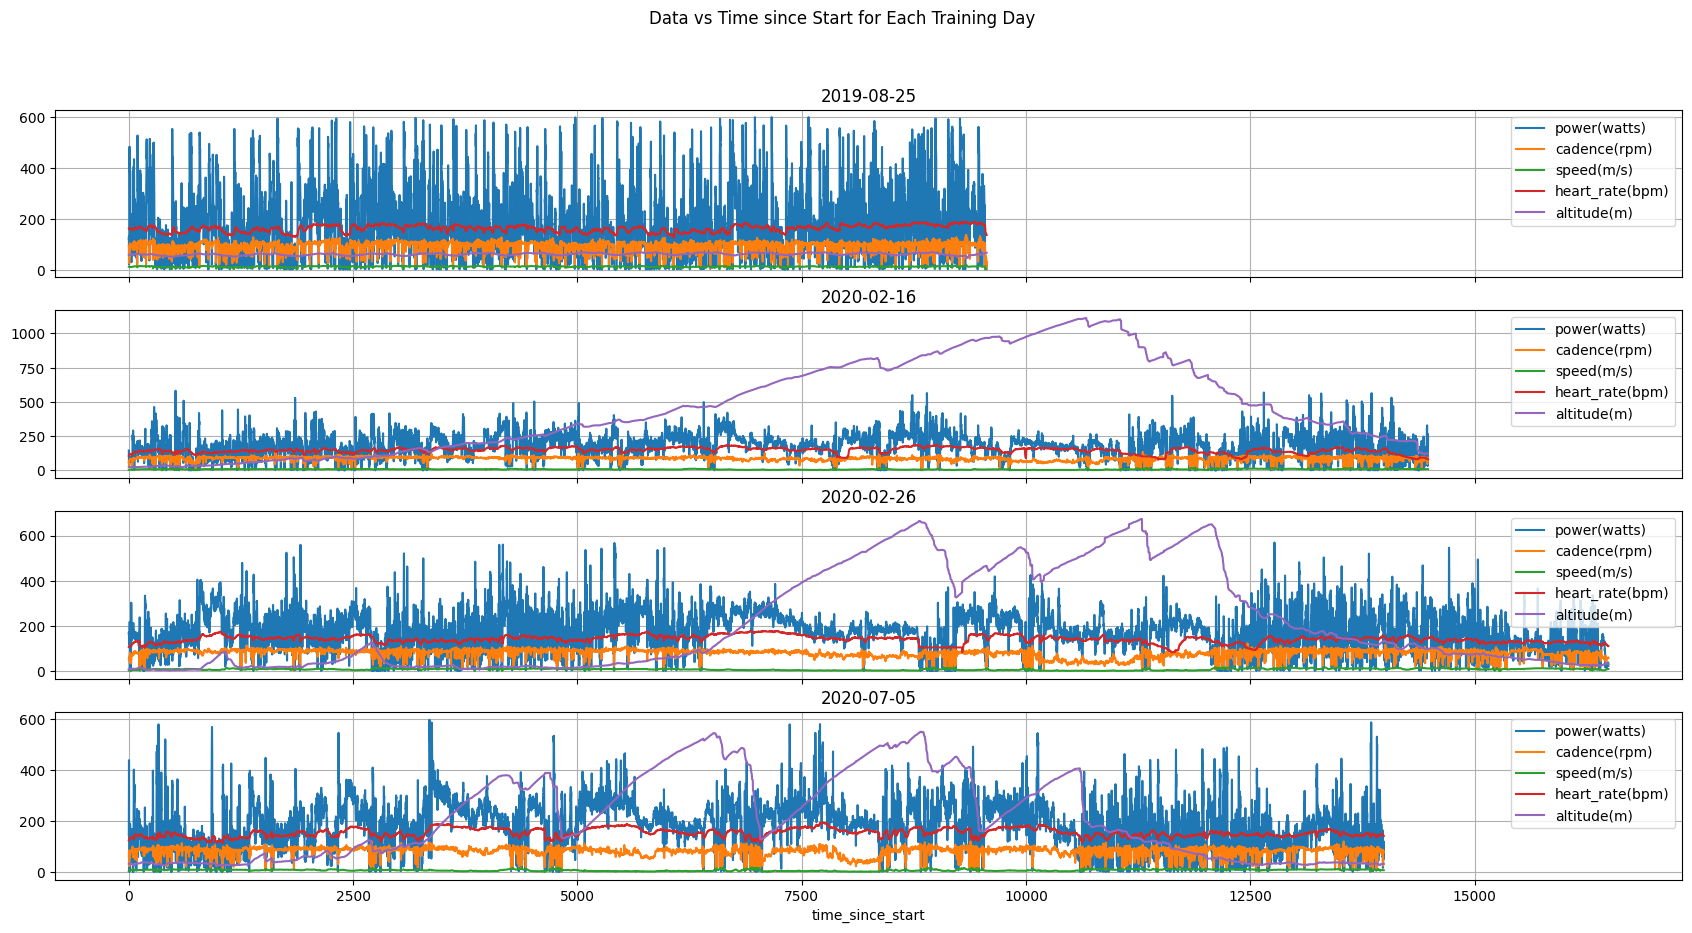

In [25]:
plot_params_per_training(['power(watts)', 'cadence(rpm)', 'speed(m/s)', 'heart_rate(bpm)', 'altitude(m)'])

# Previsioni

In [26]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

Di seguito sono riportati i modelli utilizzati per le previsioni. Per ogni modello sono riportati i parametri utilizzati e i risultati ottenuti.
Abbiamo deciso di provare diversi modelli per capire quale fosse il migliore per il nostro dataset. In particolare abbiamo provato i seguenti modelli:
- Modelli lineari
    - *Linear Regression*
    - *Ridge Regression*
    - *Lasso Regression*
    - *Elastic Net*
- Modelli Kernel
    - *KernelRidge*
- Modelli ad albero
    - *Decision Tree Regressor*
    - *Random Forest Regressor*
    - *XGBoost Regressor*
    - *LightGBM Regressor*
    
Per ciascuno di essi abbiamo fatto un tuning degli iperparametri per ottenere i migliori risultati possibili.

In [27]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Definizione dei modelli

Per l'addestramento abbiamo deciso di utilizzare la cross validation con 5 fold. Inoltre abbiamo deciso di aggregare tutte le pipeline in un unico dizionario per poterle richiamare più facilmente.
Con il metodo `get_pipe_grid(type)` si restituisce l'opportuna pipeline e il dizionario di iperparametri da utilizzare per il tuning. Il parametro `type` può assumere i seguenti valori:
- `linear`: modelli lineari
- `kernel`: modelli kernel
- `tree`: modelli ad albero

In [28]:
def get_pipe_grid(type):
    pipelines = {
        "linear": {
            "pipe": Pipeline([
                ("poly", PolynomialFeatures(include_bias=False)),
                ("std", None),
                ("regressor", None)
            ]),
            "grid_common": {
                "poly__degree": [3, 4, 5],
                "std": [StandardScaler()],
            },
            "grid_regressors": [
                {
                    "regressor": [LinearRegression()],
                },
                {
                    "regressor": [ElasticNet()],
                    "regressor__alpha": [0.01, 0.1, 1],
                    "regressor__l1_ratio": [0.0, 0.5, 1.0],
                },
            ]
        },
        "kernel": {
            "pipe": Pipeline([
                ("std", None),
                ("regressor", None)
            ]),
            "grid_common": {
                "std": [StandardScaler()],
                "regressor": [KernelRidge()],
                'regressor__alpha': [0.1],
            },
            "grid_regressors": [
                {
                    "regressor__kernel": ["poly"],
                    'regressor__degree': [3],
                },
                {
                    "regressor__kernel": ["rbf"],
                    "regressor__gamma": [0.1],
                }
            ]
        },
        "tree": {
            "pipe": Pipeline([
                ("std", None),
                ("regressor", None)
            ]),
            "grid_common": {
                "std": [StandardScaler()],
                "regressor__max_depth": [5,10,15],
            },
            "grid_regressors": [
                {
                    "regressor": [DecisionTreeRegressor()],
                },
                {
                    "regressor": [RandomForestRegressor()],
                    "regressor__n_estimators": [100,1000],
                },
                {
                    "regressor": [LGBMRegressor()],
                    "regressor__n_estimators": [100,1000],
                    "regressor__learning_rate": [0.01,0.1],
                },
                {
                    "regressor": [XGBRegressor()],
                    "regressor__n_estimators": [100,1000],
                    "regressor__learning_rate": [0.01,0.1],
                }
            ]
        }
    }
    return pipelines[type]["pipe"], [dict(pipelines[type]["grid_common"], **params) for params in pipelines[type]["grid_regressors"]]

Attraverso il metodo `get_trained_model(type, X_train, y_train, randomized)` ci consente di restituire il miglior modello addestrato fra tutti quelli provati attraverso la grid/randomized search.
Il metodo ha i seguenti parametri:
- `type`: tipo di modello da addestrare, i valori assunti sono gli stessi del metodo precedente. Serve infatti per richiamare il metodo `get_pipe_grid(type)`
- `X_train`: training set
- `y_train`: target set
- `randomized`: booleano che indica se utilizzare la *grid search* o la *randomized search*

In [29]:
def get_trained_model(type, X_train, y_train, num_jobs):
    pipe, grid = get_pipe_grid(type)
    model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=num_jobs)
    model.fit(X_train, y_train)
    return model

In [30]:
import utilities
from utilities import print_eval

## Previsione battito

In questa sezione vengono riportati i modelli utilizzati per la previsione del battito cardiaco. Per ogni modello sono riportati i parametri utilizzati e i risultati ottenuti.
Come prima cosa costruiamo il training set `X_hr` droppando dal dataset i parametri non necessari.
In particolare abbiamo deciso di droppare, fra le altre, anche `hr_zone`, questo perché in una prima versione del codice, i modelli addestrati, come ci si poteva aspettare, davano troppa importanza a questa feature, trascurando le altre. Essendoci una troppo alta correlazione fra `hr_zone` e `heart_rate(bmp)`, abbiamo deciso di droppare `hr_zone` per evitare questo problema.

In [31]:
X_hr = combined_df.drop(['heart_rate(bpm)','altitude(m)','avg_power(watts)','slope_percent','temperature(C)','hr_zone','pwr_zone','altitude_diff(m)','distance_diff(m)','left_pco(mm)','right_pco(mm)','power_left(watts)','power_right(watts)','accumulated_power(watts)'], axis=1)
y_hr = combined_df['heart_rate(bpm)']
X_train, X_val, y_train, y_val = train_test_split(X_hr, y_hr, test_size=1/3, random_state=42)

### Regressione lineare

Con modelli di regressione lineare si sono ottenuti i seguenti risultati
- Mean squared error: 124.87
- Relative error: 5.64805%
- R2: 0.64311

tramite il miglior modello (LinearRegression con poly_degree 5 e StandardScaler) ottenuto mediante una Grid Search.

In [32]:
liner_models_gs = get_trained_model('linear', X_train, y_train, -1)
linear_models_gs_res = pd.DataFrame(liner_models_gs.cv_results_).sort_values("mean_test_score", ascending=False)
print_eval(X_val, y_val, liner_models_gs)
linear_models_gs_res

   Mean squared error:       124.87
       Relative error:     5.64805%
R-squared coefficient:      0.64311


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2        4.183142      0.178734         0.098058        0.007430   
1        1.764160      0.087534         0.047819        0.004370   
0        0.678084      0.051650         0.034655        0.017114   
23      31.975260      2.692763         0.100019        0.001077   
22      35.242163      0.982691         0.099289        0.007548   
21      39.242228      1.061338         0.099265        0.006570   
14      15.022623      0.857366         0.050174        0.003133   
13      15.736010      0.981730         0.057091        0.007229   
12      18.165947      0.608562         0.053150        0.003376   
5        6.808739      0.826277         0.025623        0.004879   
4        6.915131      0.754107         0.019288        0.001622   
24      39.848438      1.846889         0.110446        0.005977   
3        7.445503      0.516831         0.022103        0.001805   
26      25.498706      1.007601         0.050719        0.013068   
25      30.093856      1.302444         0.099185        0.029897   
17      13.232793      0.852680         0.055266        0.006554   
15      17.318315      1.318851         0.057422        0.004652   
16      14.911203      1.063869         0.052767        0.003766   
8        4.797872      1.194768         0.025811        0.002527   
7        7.051168      0.702930         0.021817        0.003760   
6        6.536049      0.508811         0.026149        0.003318   
27      27.030144      0.279599         0.031414        0.003594   
18      21.636595      1.095856         0.057104        0.007535   
28      17.478474      0.824827         0.080094        0.012830   
19       4.926713      0.300221         0.063562        0.006269   
29      12.232443      0.507746         0.079483        0.014544   
20       5.513168      0.580785         0.051419        0.005448   
9       10.532424      0.612816         0.024370        0.004914   
11       0.984867      0.158456         0.026740        0.003177   
10       1.052297      0.112701         0.026030        0.001481   

   param_poly__degree     param_regressor         param_std  \
2                   5  LinearRegression()  StandardScaler()   
1                   4  LinearRegression()  StandardScaler()   
0                   3  LinearRegression()  StandardScaler()   
23                  5        ElasticNet()  StandardScaler()   
22                  5        ElasticNet()  StandardScaler()   
21                  5        ElasticNet()  StandardScaler()   
14                  4        ElasticNet()  StandardScaler()   
13                  4        ElasticNet()  StandardScaler()   
12                  4        ElasticNet()  StandardScaler()   
5                   3        ElasticNet()  StandardScaler()   
4                   3        ElasticNet()  StandardScaler()   
24                  5        ElasticNet()  StandardScaler()   
3                   3        ElasticNet()  StandardScaler()   
26                  5        ElasticNet()  StandardScaler()   
25                  5        ElasticNet()  StandardScaler()   
17                  4        ElasticNet()  StandardScaler()   
15                  4        ElasticNet()  StandardScaler()   
16                  4        ElasticNet()  StandardScaler()   
8                   3        ElasticNet()  StandardScaler()   
7                   3        ElasticNet()  StandardScaler()   
6                   3        ElasticNet()  StandardScaler()   
27                  5        ElasticNet()  StandardScaler()   
18                  4        ElasticNet()  StandardScaler()   
28                  5        ElasticNet()  StandardScaler()   
19                  4        ElasticNet()  StandardScaler()   
29                  5        ElasticNet()  StandardScaler()   
20                  4        ElasticNet()  StandardScaler()   
9                   3        ElasticNet()  StandardScaler()   
11                  3        ElasticNet()  StandardScaler()   
10   

### Regressione con funzioni kernel

Con modelli di regressione con funzioni Kernel si sono ottenuti i seguenti risultati
- Mean squared error: 138.14
- Relative error: 5.92203%
- R2: 0.60519

tramite il miglior modello (KernelRidge con alpha 0.1, gamma 0.1 e kernel rbf) ottenuto con una Grid Search.

In [34]:
krm_gs = get_trained_model('kernel', X_train, y_train, 1)
krm_gs_res = pd.DataFrame(krm_gs.cv_results_).sort_values("mean_test_score", ascending=False)
print_eval(X_val, y_val, krm_gs)
krm_gs_res

   Mean squared error:       138.14
       Relative error:     5.92203%
R-squared coefficient:      0.60519


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1      64.529199      0.650002         1.855052        0.014168   
0      70.888769      2.443267         3.016150        0.016780   

                                   param_regressor param_regressor__alpha  \
1  KernelRidge(alpha=0.1, gamma=0.1, kernel='rbf')                    0.1   
0  KernelRidge(alpha=0.1, gamma=0.1, kernel='rbf')                    0.1   

  param_regressor__degree param_regressor__kernel         param_std  \
1                     NaN                     rbf  StandardScaler()   
0                       3                    poly  StandardScaler()   

  param_regressor__gamma                                             params  \
1                    0.1  {'regressor': KernelRidge(alpha=0.1, gamma=0.1...   
0                    NaN  {'regressor': KernelRidge(alpha=0.1, gamma=0.1...   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
1           0.614430           0.602838           0.609749           0.603021   
0           0.546963           0.540231           0.544223           0.541412   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
1           0.608109         0.607629        0.004363                1  
0           0.544033         0.543372        0.002356                2

### Alberi di regressione

Con modelli di regressione ad albero si sono ottenuti i seguenti risultati

- Mean squared error: 5.3281
- RMSPE: 0.016503
- R2: 0.98477

tramite il miglior modello (XGBoost con max_depth 10, StandardScaler, n_estimators 1000 e learning_rate 0.1) ottenuto con una Grid Search.

In [36]:
tree_gs = get_trained_model('tree', X_train, y_train, -1)
tree_gs_res = pd.DataFrame(tree_gs.cv_results_).sort_values("mean_test_score", ascending=False)
print_eval(X_val, y_val, tree_gs, tree=True)
tree_gs_res

   Mean squared error:       5.3281
    RMSPE:     0.016503
R-squared coefficient:      0.98477


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
30      45.331487      7.445072         0.125014        0.116843   
32      52.600078      1.574296         0.245983        0.240908   
26      94.374562     18.620768         0.224761        0.288669   
31      12.910944      5.493774         0.026998        0.019988   
28      43.825873      0.388652         0.015183        0.002919   
24      75.433861      3.838293         0.038760        0.005304   
29       7.011109      4.019999         0.017694        0.007193   
20      92.242654      1.391495         0.044086        0.011279   
18      67.318355      4.426715         0.046000        0.008993   
16      16.304421      6.896700         0.038547        0.004367   
8      370.795162     20.326792         0.871973        0.027239   
7       32.784946      2.830403         0.117657        0.039469   
2        0.386220      0.020111         0.003920        0.001536   
19       2.552704      0.196088         0.012602        0.004757   
14      24.465664      5.337055         0.051344        0.010082   
17       2.046641      0.234328         0.009049        0.000706   
12      81.282368     40.053454         0.046216        0.006260   
27       3.503094      0.077696         0.005224        0.000679   
22      24.284851      0.319598         0.016010        0.002082   
15       1.452211      0.031627         0.009151        0.001616   
10     249.876312     19.926086         0.041012        0.006457   
6      281.358679      1.084031         0.579351        0.062874   
5       20.845888      0.515139         0.054331        0.005020   
1        0.257945      0.015077         0.003016        0.001524   
13       2.588150      0.487647         0.009648        0.001439   
11     136.938110     17.118383         0.010165        0.002130   
3        9.560497      0.371870         0.026394        0.003412   
4      127.278622     21.185188         0.336459        0.079092   
9      177.708447     25.035757         0.048032        0.005547   
0        0.125781      0.008643         0.002215        0.000511   
25       6.784826      0.117365         0.008541        0.001706   
23       4.930975      0.217249         0.007627        0.000803   
21       1.890574      0.283562         0.004342        0.000439   

                                      param_regressor  \
30  XGBRegressor(base_score=None, booster=None, ca...   
32  XGBRegressor(base_score=None, booster=None, ca...   
26  XGBRegressor(base_score=None, booster=None, ca...   
31  XGBRegressor(base_score=None, booster=None, ca...   
28  XGBRegressor(base_score=None, booster=None, ca...   
24  XGBRegressor(base_score=None, booster=None, ca...   
29  XGBRegressor(base_score=None, booster=None, ca...   
20                                    LGBMRegressor()   
18                                    LGBMRegressor()   
16                                    LGBMRegressor()   
8                             RandomForestRegressor()   
7                             RandomForestRegressor()   
2                             DecisionTreeRegressor()   
19                                    LGBMRegressor()   
14                                    LGBMRegressor()   
17                                    LGBMRegressor()   
12                                    LGBMRegressor()   
27  XGBRegressor(base_score=None, booster=None, ca...   
22  XGBRegressor(base_score=None, booster=None, ca...   
15                                    LGBMRegressor()   
10                                    LGBMRegressor()   
6                             RandomForestRegressor()   
5                             RandomForestRegressor()   
1                             DecisionTreeRegressor()   
13                                    LGBMRegressor()   
11                                    LGBMRegressor()   
3                             RandomForestRegressor()   
4                             RandomForestRegressor()   
9                                     

### Reti neurali

Abbiamo deciso di provare anche le reti neurali per la previsione del battito. In particolare abbiamo provato *Multi Layer Perceptron* (sklearn). Lo score cosi ottenuto è il seguente

- Mean squared error: 88.749
- Relative error: 4.82350%
- R-squared coefficient: 0.74635

In [38]:
from sklearn.neural_network import MLPRegressor

pipe = Pipeline([
    ("std", StandardScaler()),
    ("regressor", MLPRegressor())
])

grid = {
    "regressor__hidden_layer_sizes": [(256, 256)],
    "regressor__activation": ["relu"],
    "regressor__max_iter": [2000],
    "regressor__batch_size": [128],
    "regressor__alpha": [0.01]

}

model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=-1)
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

   Mean squared error:       88.749
       Relative error:     4.82350%
R-squared coefficient:      0.74635


In [39]:
model_res = pd.DataFrame(model.cv_results_).sort_values("mean_test_score", ascending=False)

### Confronto fra modelli

Di seguito è riportato un confronto fra i modelli per la previsione del battito. Come si può vedere, i migliori risultati sono ottenuti tramite i modelli ad Albero.
Questo perché ottengono R2 molto prossimi a 1, errore relativo molto basso e tempi di addestamento molto simili a quelli dei modelli lineari.

Il peggior modello in termini score / tempi d'addestamento è il Perceptron, infatti otteiene un coefficiente R2 comparabile a modelli ad albero non estremamente performanti ma richiedendo tempi d'addestramento quasi 8 volte maggiori.

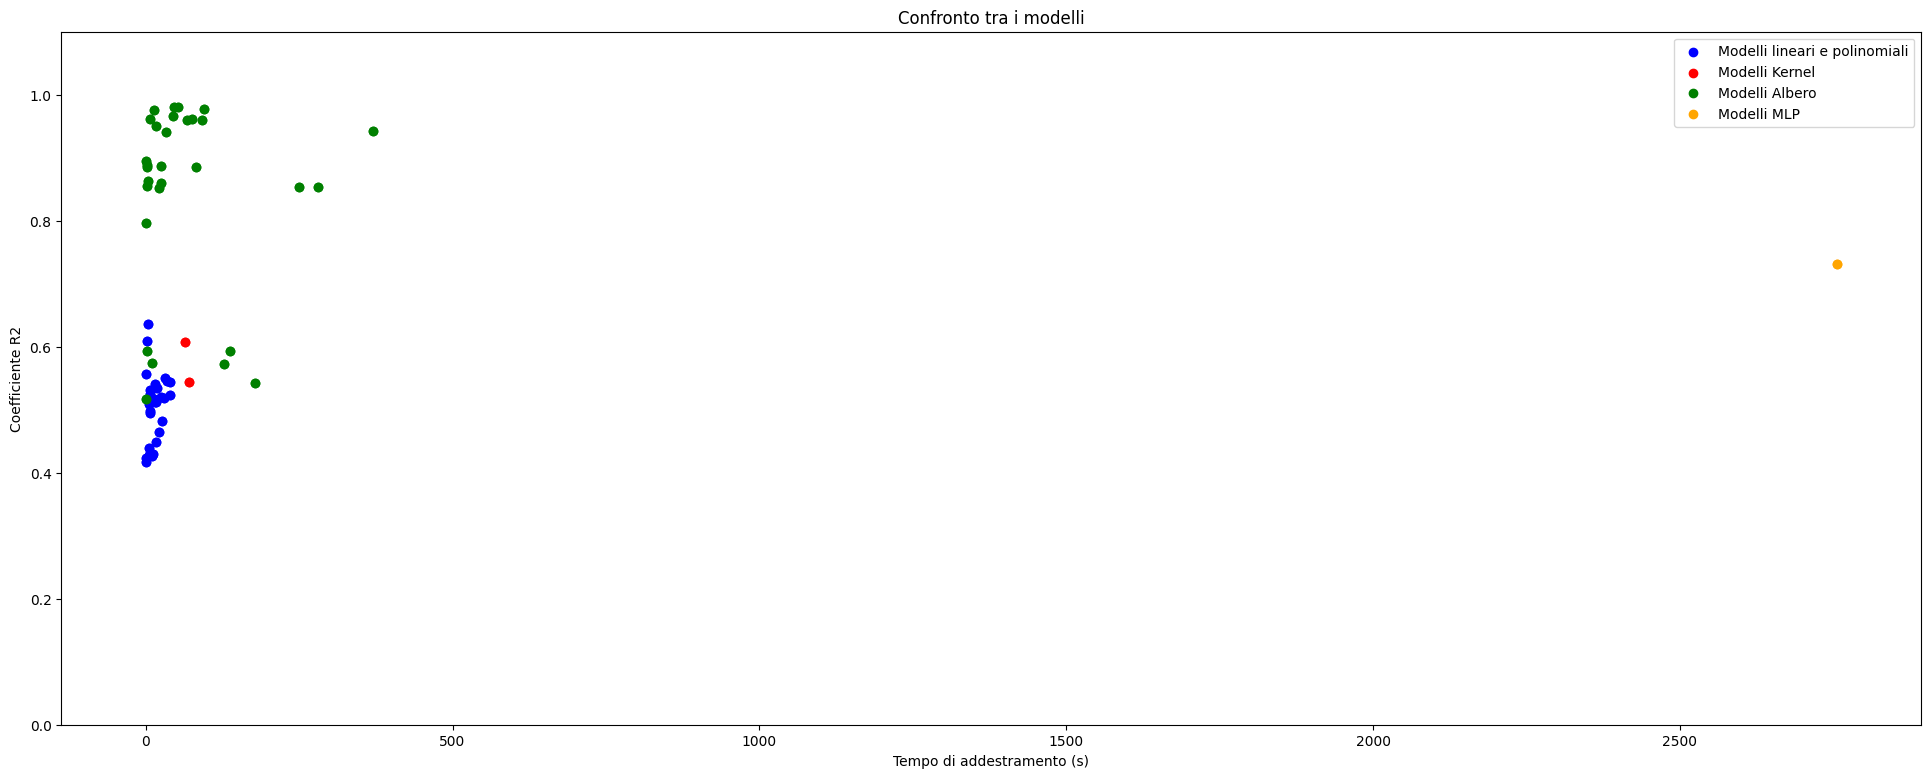

In [40]:
fig, ax = plt.subplots(figsize=(24, 9))

linear_models = pd.concat([linear_models_gs_res, linear_models_gs_res], axis=0)
scatter_linear = ax.scatter(linear_models['mean_fit_time'], linear_models['mean_test_score'], color='blue', label='Modelli lineari e polinomiali')

krm_models = pd.concat([krm_gs_res, krm_gs_res], axis=0)
scatter_kernel = ax.scatter(krm_models['mean_fit_time'], krm_models['mean_test_score'], color='red', label='Modelli Kernel')

tree_models = pd.concat([tree_gs_res, tree_gs_res], axis=0)
scatter_tree = ax.scatter(tree_models['mean_fit_time'], tree_models['mean_test_score'], color='green', label='Modelli Albero')

mlp_models = pd.concat([model_res, model_res], axis=0)
scatter_mlp = ax.scatter(mlp_models['mean_fit_time'], mlp_models['mean_test_score'], color='orange', label='Modelli MLP')

ax.set_xlabel('Tempo di addestramento (s)')
ax.set_ylabel('Coefficiente R2')
ax.set_title('Confronto tra i modelli')
ax.legend()
plt.ylim(0, 1.1)
plt.show()

## Previsione Potenza

La previsione della potenza è del tutto identica a quella fatta per il battito. La differenza sta nel fatto che il training set è differente. In particolare, per la previsione della potenza, abbiamo deciso di droppare anche `power_zone` per lo stesso motivo per cui abbiamo droppato `hr_zone` per la previsione del battito.

In [41]:
X_watt = combined_df.drop(['power(watts)','altitude(m)','avg_power(watts)','slope_percent','temperature(C)','hr_zone','pwr_zone','altitude_diff(m)','distance_diff(m)','left_pco(mm)','right_pco(mm)','power_left(watts)','power_right(watts)','accumulated_power(watts)'], axis=1)
y_watt = combined_df['avg_power(watts)']
X_train, X_val, y_train, y_val = train_test_split(X_watt, y_watt, test_size=1/3, random_state=42)

### Regressione con modelli lineari e polinomiali

Con modelli di regressione lineare si sono ottenuti i seguenti risultati
- Mean squared error: 3889.6
- Relative error: 63.08378%
- R2: 0.47936

tramite il miglior modello (LinearRegression con poly_degree 4 e StandardScaler) ottenuto mediante una Grid Search.

In [42]:
linear_gs = get_trained_model('linear', X_train, y_train, -1)
print_eval(X_val, y_val, linear_gs)
linear_gs_res=pd.DataFrame(linear_gs.cv_results_).sort_values("mean_test_score", ascending=False)
linear_gs_res

   Mean squared error:       3889.6
       Relative error:    63.08378%
R-squared coefficient:      0.47936


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1        1.718237      0.043945         0.040991        0.003504   
2        4.036996      0.010646         0.095693        0.008716   
0        0.525395      0.167500         0.021192        0.007444   
23      35.003245      2.341244         0.098315        0.006962   
22      34.074794      1.921638         0.105632        0.009081   
14      15.491232      0.856102         0.047107        0.001757   
21      35.349127      1.159105         0.101234        0.011026   
13      15.804285      1.687246         0.047250        0.003416   
26      27.358426      0.544971         0.068966        0.013301   
5        6.215211      0.656932         0.022461        0.005875   
12      16.441346      0.907267         0.052099        0.003692   
17      13.578096      1.742418         0.049417        0.004674   
4        6.324812      0.559888         0.023148        0.005802   
25      32.161468      2.633514         0.094473        0.012710   
24      34.105025      1.120247         0.106135        0.010201   
3        6.764611      0.587178         0.019750        0.001329   
8        5.533561      0.371733         0.022870        0.001292   
16      15.220962      1.856239         0.050934        0.005062   
15      16.251547      1.390195         0.052083        0.003326   
7        6.846224      0.651712         0.023262        0.003082   
6        6.019168      0.429902         0.022328        0.006467   
29      18.758303      3.008926         0.065761        0.026832   
20      12.815180      1.714672         0.049328        0.002062   
11       3.007939      1.742900         0.021995        0.001161   
27      29.158220      0.744288         0.030395        0.001160   
28      23.928681      0.554766         0.053322        0.009740   
19       8.313213      0.755365         0.051596        0.004661   
18      19.304902      1.647939         0.047949        0.005473   
10       1.296699      0.146935         0.023805        0.002862   
9        9.141194      0.687621         0.020611        0.002380   

   param_poly__degree     param_regressor         param_std  \
1                   4  LinearRegression()  StandardScaler()   
2                   5  LinearRegression()  StandardScaler()   
0                   3  LinearRegression()  StandardScaler()   
23                  5        ElasticNet()  StandardScaler()   
22                  5        ElasticNet()  StandardScaler()   
14                  4        ElasticNet()  StandardScaler()   
21                  5        ElasticNet()  StandardScaler()   
13                  4        ElasticNet()  StandardScaler()   
26                  5        ElasticNet()  StandardScaler()   
5                   3        ElasticNet()  StandardScaler()   
12                  4        ElasticNet()  StandardScaler()   
17                  4        ElasticNet()  StandardScaler()   
4                   3        ElasticNet()  StandardScaler()   
25                  5        ElasticNet()  StandardScaler()   
24                  5        ElasticNet()  StandardScaler()   
3                   3        ElasticNet()  StandardScaler()   
8                   3        ElasticNet()  StandardScaler()   
16                  4        ElasticNet()  StandardScaler()   
15                  4        ElasticNet()  StandardScaler()   
7                   3        ElasticNet()  StandardScaler()   
6                   3        ElasticNet()  StandardScaler()   
29                  5        ElasticNet()  StandardScaler()   
20                  4        ElasticNet()  StandardScaler()   
11                  3        ElasticNet()  StandardScaler()   
27                  5        ElasticNet()  StandardScaler()   
28                  5        ElasticNet()  StandardScaler()   
19                  4        ElasticNet()  StandardScaler()   
18                  4        ElasticNet()  StandardScaler()   
10                  3        ElasticNet()  StandardScaler()   
9    

### Regressione con funzioni kernel

Con modelli di regressione con funzioni Kernel si sono ottenuti i seguenti risultati
- Mean squared error: 3720.6
- Relative error: 57.88188%
- R2: 0.50198

tramite il miglior modello (KernelRidge con alpha 0.1, gamma 0.1 e kernel rbf) ottenuto con una Grid Search.

In [44]:
kernel_gs = get_trained_model('kernel', X_train, y_train, 1)
print_eval(X_val, y_val, kernel_gs)
kernel_gs_res=pd.DataFrame(kernel_gs.cv_results_).sort_values("mean_test_score", ascending=False)
kernel_gs_res

   Mean squared error:       3720.6
       Relative error:    57.88188%
R-squared coefficient:      0.50198


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1      62.693573      1.814208         1.817681        0.015652   
0      71.598581      2.760771         2.990863        0.018997   

                                   param_regressor param_regressor__alpha  \
1  KernelRidge(alpha=0.1, gamma=0.1, kernel='rbf')                    0.1   
0  KernelRidge(alpha=0.1, gamma=0.1, kernel='rbf')                    0.1   

  param_regressor__degree param_regressor__kernel         param_std  \
1                     NaN                     rbf  StandardScaler()   
0                       3                    poly  StandardScaler()   

  param_regressor__gamma                                             params  \
1                    0.1  {'regressor': KernelRidge(alpha=0.1, gamma=0.1...   
0                    NaN  {'regressor': KernelRidge(alpha=0.1, gamma=0.1...   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
1           0.492659           0.507568           0.514824           0.508675   
0           0.446987           0.465443           0.471195           0.468000   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
1           0.509348         0.506615        0.007413                1  
0           0.473535         0.465032        0.009433                2

### Regressione con alberi

Con modelli di regressione ad albero si sono ottenuti i seguenti risultati
- Mean squared error: 1283.1
- RMSPE: 2.1632
- R2: 0.82826

tramite il miglior modello (XGBoost con max_depth 10, StandardScaler, n_estimators 1000 e learning_rate 0.1) ottenuto con una Grid Search.

In [46]:
watt_tree_gs = get_trained_model('tree', X_train, y_train, -1)
print_eval(X_val, y_val, watt_tree_gs, tree=True)
watt_tree_gs_res=pd.DataFrame(watt_tree_gs.cv_results_).sort_values("mean_test_score", ascending=False)
watt_tree_gs_res

   Mean squared error:       1283.1
    RMSPE:       2.1632
R-squared coefficient:      0.82826


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
30      37.907476      2.714798         0.067068        0.091566   
32      41.115555      0.809961         0.039890        0.003978   
26      84.629535     13.506930         0.252721        0.367275   
31       6.910523      1.556215         0.044508        0.018629   
28      37.418462      1.133140         0.015160        0.001106   
24      75.628425      2.920183         0.029867        0.002655   
29      11.535695      0.090597         0.009173        0.001509   
20      84.422115      0.561552         0.040013        0.006395   
18      54.323676      5.878546         0.034469        0.001528   
8      297.125127     25.190978         0.906033        0.021221   
7       33.199683      1.597515         0.148935        0.015136   
16      11.773454      1.662725         0.034566        0.003884   
19       2.049033      0.255353         0.008125        0.000394   
6      201.410415     21.922931         0.524166        0.044804   
14      25.352058      5.902034         0.039705        0.001214   
5       18.493396      0.224183         0.058965        0.005054   
17       1.827039      0.117683         0.007908        0.001597   
12      73.190515      1.894310         0.040470        0.005763   
27       3.335316      0.051499         0.005943        0.001577   
22      21.774186      0.448653         0.014916        0.002058   
15       1.563524      0.300076         0.008306        0.001504   
10     179.034149     17.321998         0.032485        0.005336   
1        0.233934      0.008645         0.002505        0.000312   
2        0.364357      0.017103         0.003604        0.000585   
3        8.738496      0.317654         0.028838        0.002641   
4      108.914863     15.342043         0.315278        0.052678   
0        0.115438      0.005435         0.002804        0.001438   
13      14.229469      2.564318         0.015163        0.005352   
11      77.217721     10.391079         0.019236        0.010072   
9      136.051996      3.903410         0.025972        0.010388   
25       9.845697      1.842354         0.023089        0.018867   
23       5.358916      0.055528         0.008921        0.000986   
21       1.230058      0.257357         0.004619        0.001194   

                                      param_regressor  \
30  XGBRegressor(base_score=None, booster=None, ca...   
32  XGBRegressor(base_score=None, booster=None, ca...   
26  XGBRegressor(base_score=None, booster=None, ca...   
31  XGBRegressor(base_score=None, booster=None, ca...   
28  XGBRegressor(base_score=None, booster=None, ca...   
24  XGBRegressor(base_score=None, booster=None, ca...   
29  XGBRegressor(base_score=None, booster=None, ca...   
20                                    LGBMRegressor()   
18                                    LGBMRegressor()   
8                             RandomForestRegressor()   
7                             RandomForestRegressor()   
16                                    LGBMRegressor()   
19                                    LGBMRegressor()   
6                             RandomForestRegressor()   
14                                    LGBMRegressor()   
5                             RandomForestRegressor()   
17                                    LGBMRegressor()   
12                                    LGBMRegressor()   
27  XGBRegressor(base_score=None, booster=None, ca...   
22  XGBRegressor(base_score=None, booster=None, ca...   
15                                    LGBMRegressor()   
10                                    LGBMRegressor()   
1                             DecisionTreeRegressor()   
2                             DecisionTreeRegressor()   
3                             RandomForestRegressor()   
4                             RandomForestRegressor()   
0                             DecisionTreeRegressor()   
13                                    LGBMRegressor()   
11                                    

### Reti neurali

Anche nel caso della potenza abbiamo provato un modello *Multi Layer Perceptron* (sklearn) i cui score sono:

- Mean squared error: 3378.6
- Relative error: 53.81716%
- R2: 0.54776

In [48]:
from sklearn.neural_network import MLPRegressor

pipe = Pipeline([
    ("std", StandardScaler()),
    ("regressor", MLPRegressor())
])

grid = {
    "regressor__hidden_layer_sizes": [(256, 256)],
    "regressor__activation": ["relu"],
    "regressor__max_iter": [2000],
    "regressor__batch_size": [128],
    "regressor__alpha": [0.01]

}

model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=-1)
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

   Mean squared error:       3378.6
       Relative error:    53.81716%
R-squared coefficient:      0.54776


In [49]:
model_res = pd.DataFrame(model.cv_results_).sort_values("mean_test_score", ascending=False)

### Confronto fra modelli

Anche in questo caso i modelli ad albero ottengono i risultati migliori, mentre il perceptron è quello che tendenzialmente ha performance peggiori.

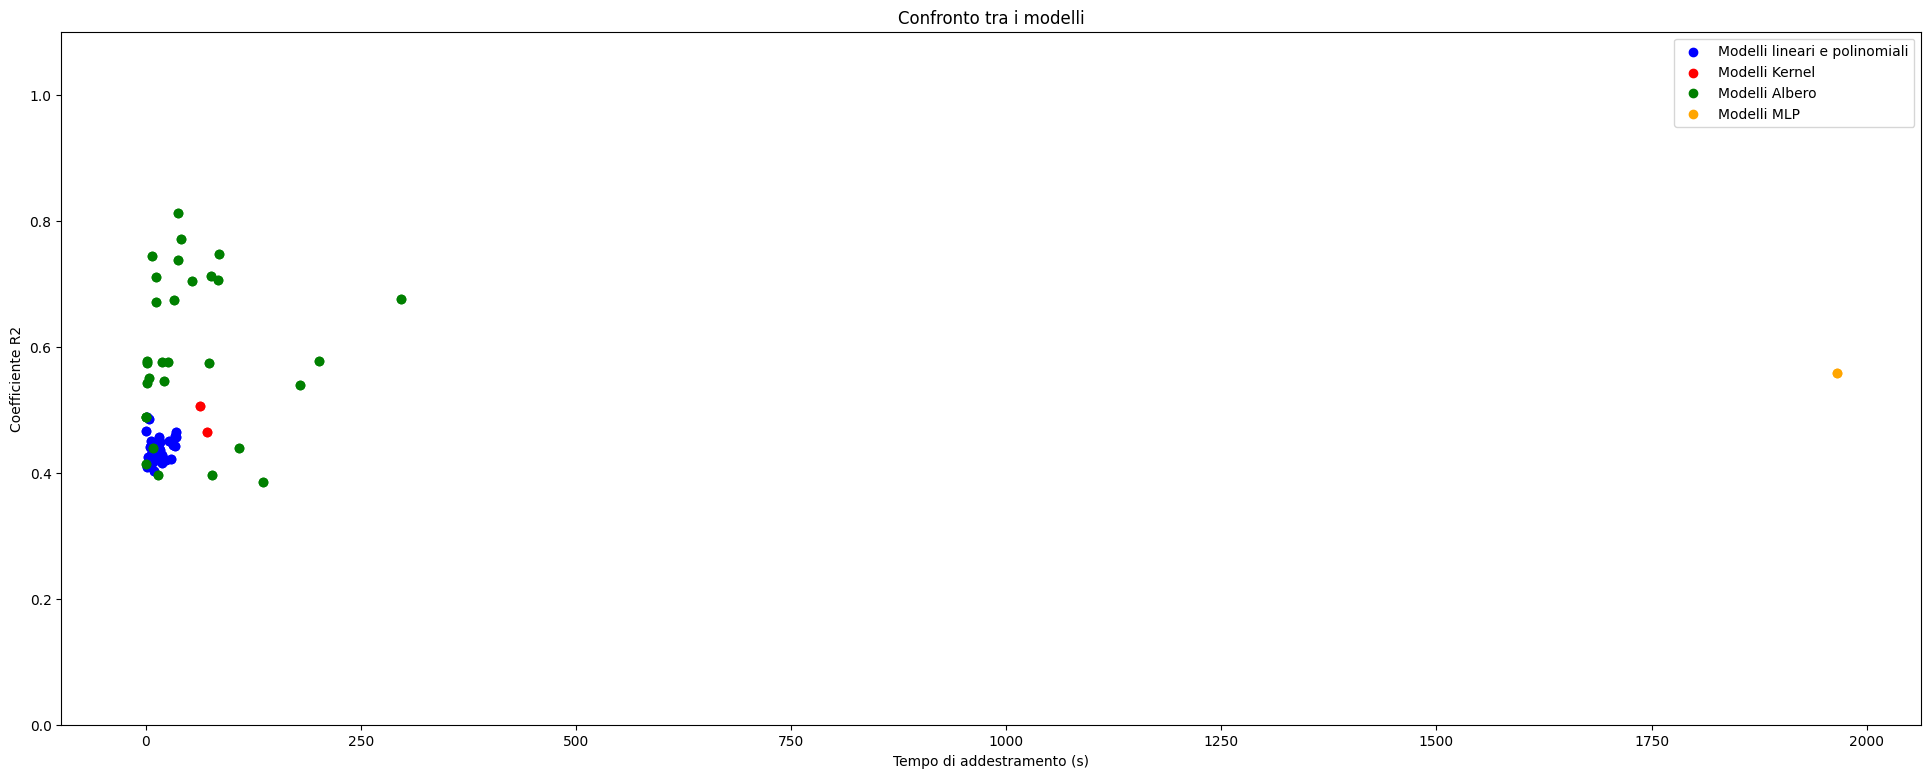

In [50]:
fig, ax = plt.subplots(figsize=(24, 9))

linear_models = pd.concat([linear_gs_res, linear_gs_res], axis=0)
scatter_linear = ax.scatter(linear_models['mean_fit_time'], linear_models['mean_test_score'], color='blue', label='Modelli lineari e polinomiali')

krm_models = pd.concat([kernel_gs_res, kernel_gs_res], axis=0)
scatter_kernel = ax.scatter(krm_models['mean_fit_time'], krm_models['mean_test_score'], color='red', label='Modelli Kernel')

tree_models = pd.concat([watt_tree_gs_res, watt_tree_gs_res], axis=0)
scatter_tree = ax.scatter(tree_models['mean_fit_time'], tree_models['mean_test_score'], color='green', label='Modelli Albero')

mlp_models = pd.concat([model_res, model_res], axis=0)
scatter_mlp = ax.scatter(mlp_models['mean_fit_time'], mlp_models['mean_test_score'], color='orange', label='Modelli MLP')

ax.set_xlabel('Tempo di addestramento (s)')
ax.set_ylabel('Coefficiente R2')
ax.set_title('Confronto tra i modelli')
ax.legend()
plt.ylim(0, 1.1)
plt.show()


# Classificazione

Di seguito sono riportate le operazioni fatte per la classificazione. In particolare si è deciso di utilizzare il modello *Decision Tree Classifier*. 

Nelle celle sottostanti vengono definite delle funzioni che consentono di rappresentare graficamente le varie zone di battito e potenza in funzione del tempo trascorso in allenamento.

In [51]:
import matplotlib.patches as mpatches

def plot_scatter_zones_per_training(feature, zone):
    color_map = {1: "darkblue", 2: "blue", 3: "aquamarine", 4: "green", 5: "yellow", 6: "orange", 7: "red"}
    
    grouped_df = combined_df.groupby(combined_df.index.date)
    
    legend_patches = [mpatches.Patch(color=color, label=f'Zone {zone}') for zone, color in color_map.items()]

    fig, axes = plt.subplots(nrows=len(grouped_df), figsize=(24, 9), sharex=True)

    for i, (allenamento, data) in enumerate(grouped_df):
        axes[i].scatter(data['time_since_start(s)'], data[feature], c=data[zone].map(color_map), s=5)
        axes[i].set_title(f'Training {allenamento}')

    fig.suptitle(f'{feature} zones for each training')
    plt.xlabel('time_since_start(s)')
    plt.ylabel(feature)
    plt.legend(handles=legend_patches, title=f'{feature} zone')
    
    plt.show()


In [52]:
def plot_zones_bars_per_training(zone):
    grouped_df = combined_df.groupby(combined_df.index.date)
    fig, axes = plt.subplots(nrows=len(grouped_df), figsize=(24, 9), sharex=True)
    for i, (allenamento, data) in enumerate(grouped_df):
        axes[i].barh(data[zone].value_counts().index, data[zone].value_counts().values)
        axes[i].set_title(f'Training {allenamento}')

    plt.xlabel('time_since_start(s)')
    plt.ylabel(zone)


## Classificazione della potenza

Abbiamo deciso di classificare la potenza sulla base della potenza istananea in funzione del tempo trascorso. Ecco perché abbiamo considerato come feature solo
- `power(watts)`
- `time_since_start(s)`

In [53]:
X = combined_df[["time_since_start(s)", "power(watts)"]]
y = combined_df['pwr_zone']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

Dal grafico seguente si nota che la maggior parte del tempo ci si trova nelle zone 1 e 2, con dei picchi su quelle più alte. Inoltre si nota che negli allenamenti del 16-02-2020 e del 05-07-2020 si è passato pochissimo tempo nella zona 7 poiché in essi vi era molta salita, dunque i grafici sono compatibili con quanto detto in precedenza.

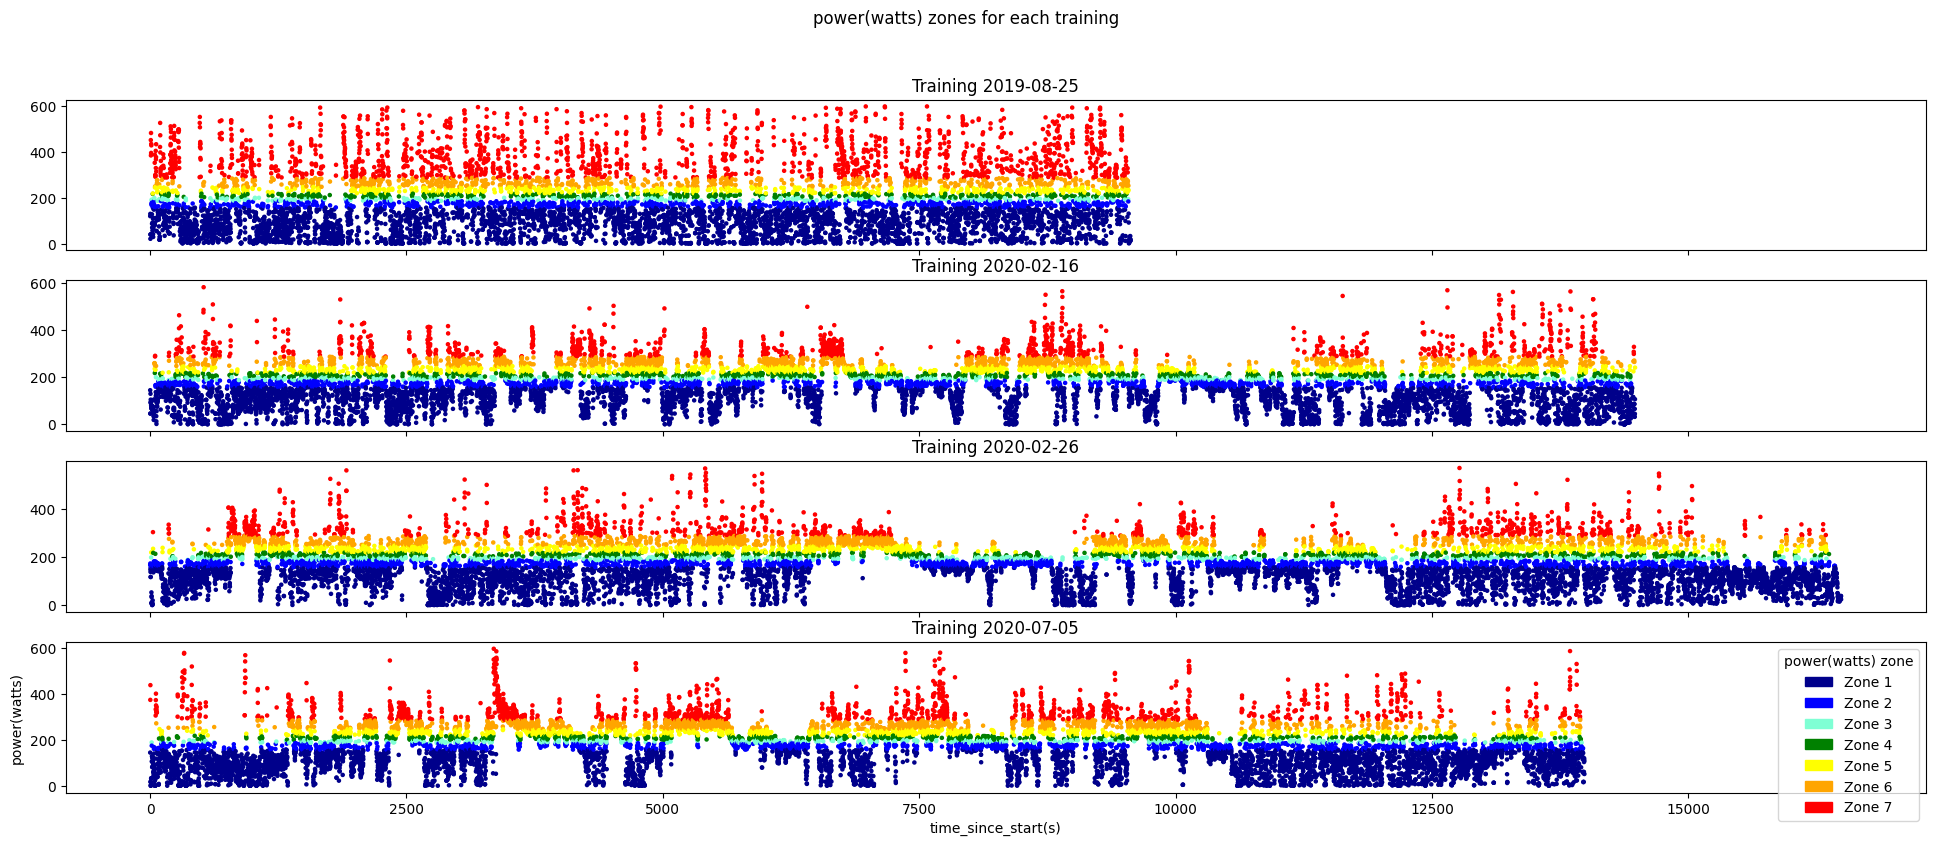

In [54]:
plot_scatter_zones_per_training('power(watts)', 'pwr_zone')

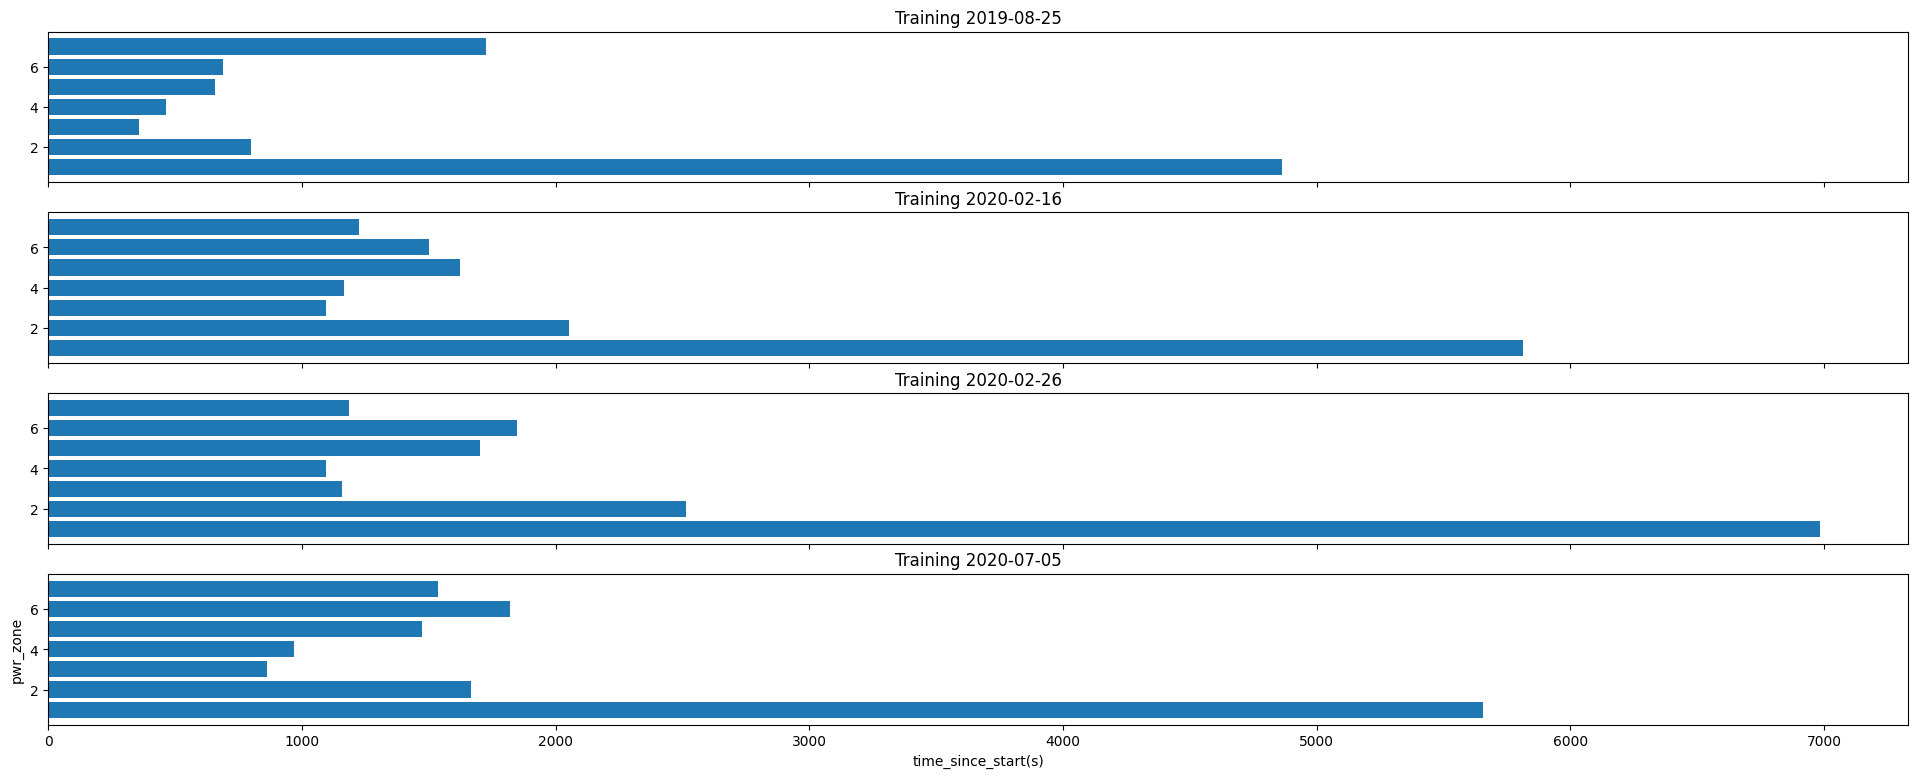

In [55]:
plot_zones_bars_per_training('pwr_zone')

Di seguito è riportata la pipeline per la classificazione della potenza. Come anticipato si è deciso di utilizzare il modello *Decision Tree Classifier*. La pipeline è composta da:
- `StandardScaler`: la grid search valuterà se è meglio standardizzare o meno i dati
- `criterion`: criterio con cui valutare la bontà di uno split
- `max_depth`: massima profondità dell'albero
- `splitter`: la strategia usata per scegliere lo split migliore su ogni nodo
- `min_samples_leaf`: numero minimo di campioni necessari per essere una foglia
- `min_samples_split`: numero minimo di campioni necessari per effettuare uno split 
- `max_features`: numero di features da considerare per la ricerca dello split migliore

|--- time_since_start(s) <= 10312.50
|   |--- power(watts) <= 186.50
|   |   |--- power(watts) <= 157.50
|   |   |   |--- class: 1
|   |   |--- power(watts) >  157.50
|   |   |   |--- class: 2
|   |--- power(watts) >  186.50
|   |   |--- power(watts) <= 247.50
|   |   |   |--- time_since_start(s) <= 7518.50
|   |   |   |   |--- power(watts) <= 218.50
|   |   |   |   |   |--- time_since_start(s) <= 7481.00
|   |   |   |   |   |   |--- power(watts) <= 200.50
|   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |--- power(watts) >  200.50
|   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |--- time_since_start(s) >  7481.00
|   |   |   |   |   |   |--- power(watts) <= 204.50
|   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |   |--- power(watts) >  204.50
|   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |--- power(watts) >  218.50
|   |   |   |   |   |--- class: 5
|   |   |   |--- time_since_start(s) >  7518.50
|   |   |   |   |--- power(watts)

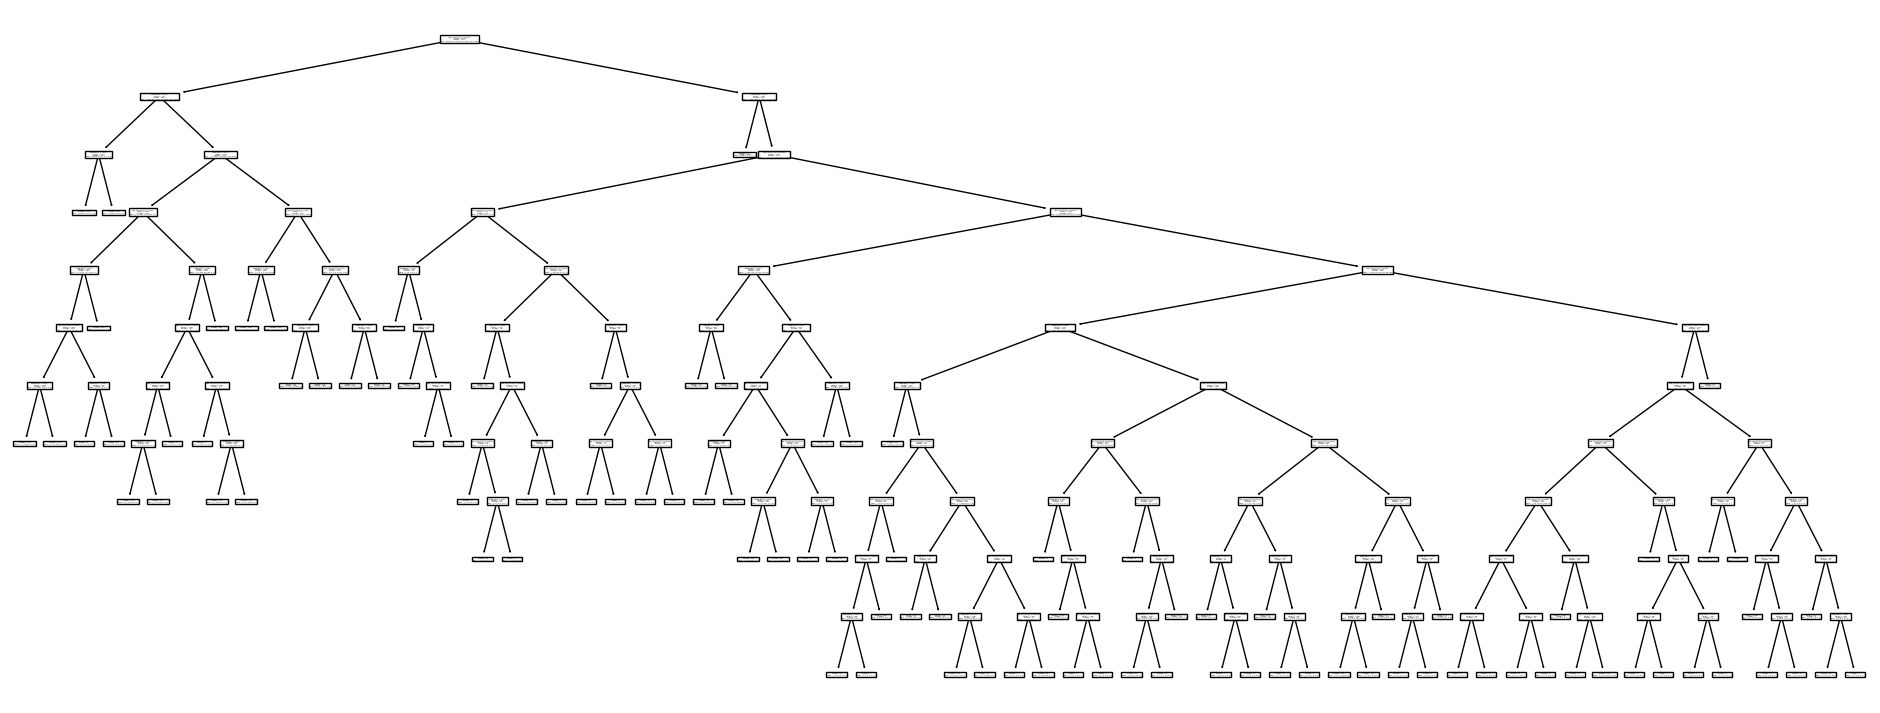

In [56]:
pipe = Pipeline([
    ("std", None),
    ("regressor", DecisionTreeClassifier())
])

grid = {
    "std": [StandardScaler(), None],
    "regressor__criterion": ["gini", "entropy", "log_loss"],
    "regressor__max_depth": [3, 5, 7, 9, 11],
    "regressor__splitter": ["best", "random"],
    "regressor__min_samples_leaf": [1, 2, 3, 4, 5],
    "regressor__min_samples_split": [2, 4, 6, 8, 10],
    "regressor__max_features": ["auto", "sqrt", "log2"]
}


model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=-1)
model.fit(X_train, y_train)

plt.figure(figsize=(24, 9))
plot_tree(model.best_estimator_["regressor"], feature_names=X_train.columns.to_list())
print(export_text(model.best_estimator_["regressor"], feature_names=X_train.columns.to_list()))

In [57]:
model_res = pd.DataFrame(model.cv_results_).sort_values("mean_test_score", ascending=False)

In [58]:
from sklearn.neural_network import MLPClassifier

pipe = Pipeline([
    ("std", StandardScaler()),
    ("regressor", MLPClassifier())
])

grid = {
    "regressor__hidden_layer_sizes": [(256, 256)],
    "regressor__activation": ["relu"],
    "regressor__max_iter": [2000],
    "regressor__batch_size": [128],
    "regressor__alpha": [0.01]

}

model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=-1)
model.fit(X_train, y_train)
print_eval(X_test, y_test, model)


   Mean squared error:     0.010456
       Relative error:     0.24765%
R-squared coefficient:      0.99788


In [59]:
neural_res = pd.DataFrame(model.cv_results_).sort_values("mean_test_score", ascending=False)

### Confronto fra modelli

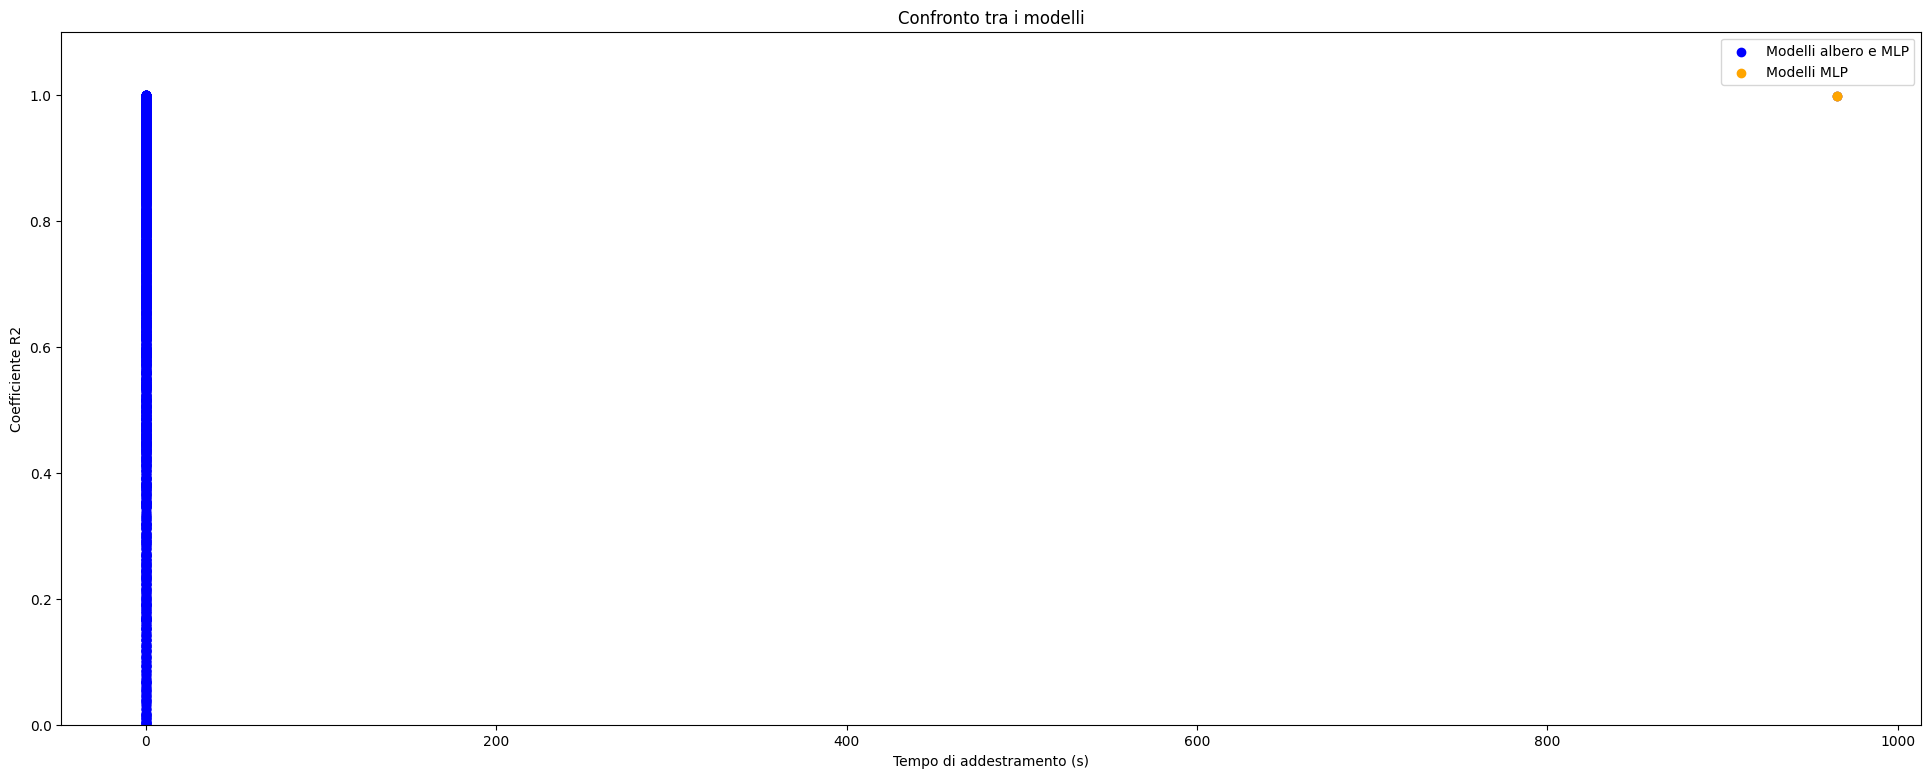

In [60]:
fig, ax = plt.subplots(figsize=(24, 9))

model_res = pd.concat([model_res, neural_res], axis=0)
scatter = ax.scatter(model_res['mean_fit_time'], model_res['mean_test_score'], color='blue', label='Modelli albero e MLP')

neural_res = pd.concat([neural_res, neural_res], axis=0)
scatter = ax.scatter(neural_res['mean_fit_time'], neural_res['mean_test_score'], color='orange', label='Modelli MLP')

ax.set_xlabel('Tempo di addestramento (s)')
ax.set_ylabel('Coefficiente R2')
ax.set_title('Confronto tra i modelli')
ax.legend()
plt.ylim(0, 1.1)
plt.show()

## Classificazione dei battiti

La classificazione dei battiti è del tutto equivalente a quella della potenza.

In [61]:
X = combined_df[["time_since_start(s)", "heart_rate(bpm)"]]
y = combined_df['hr_zone']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

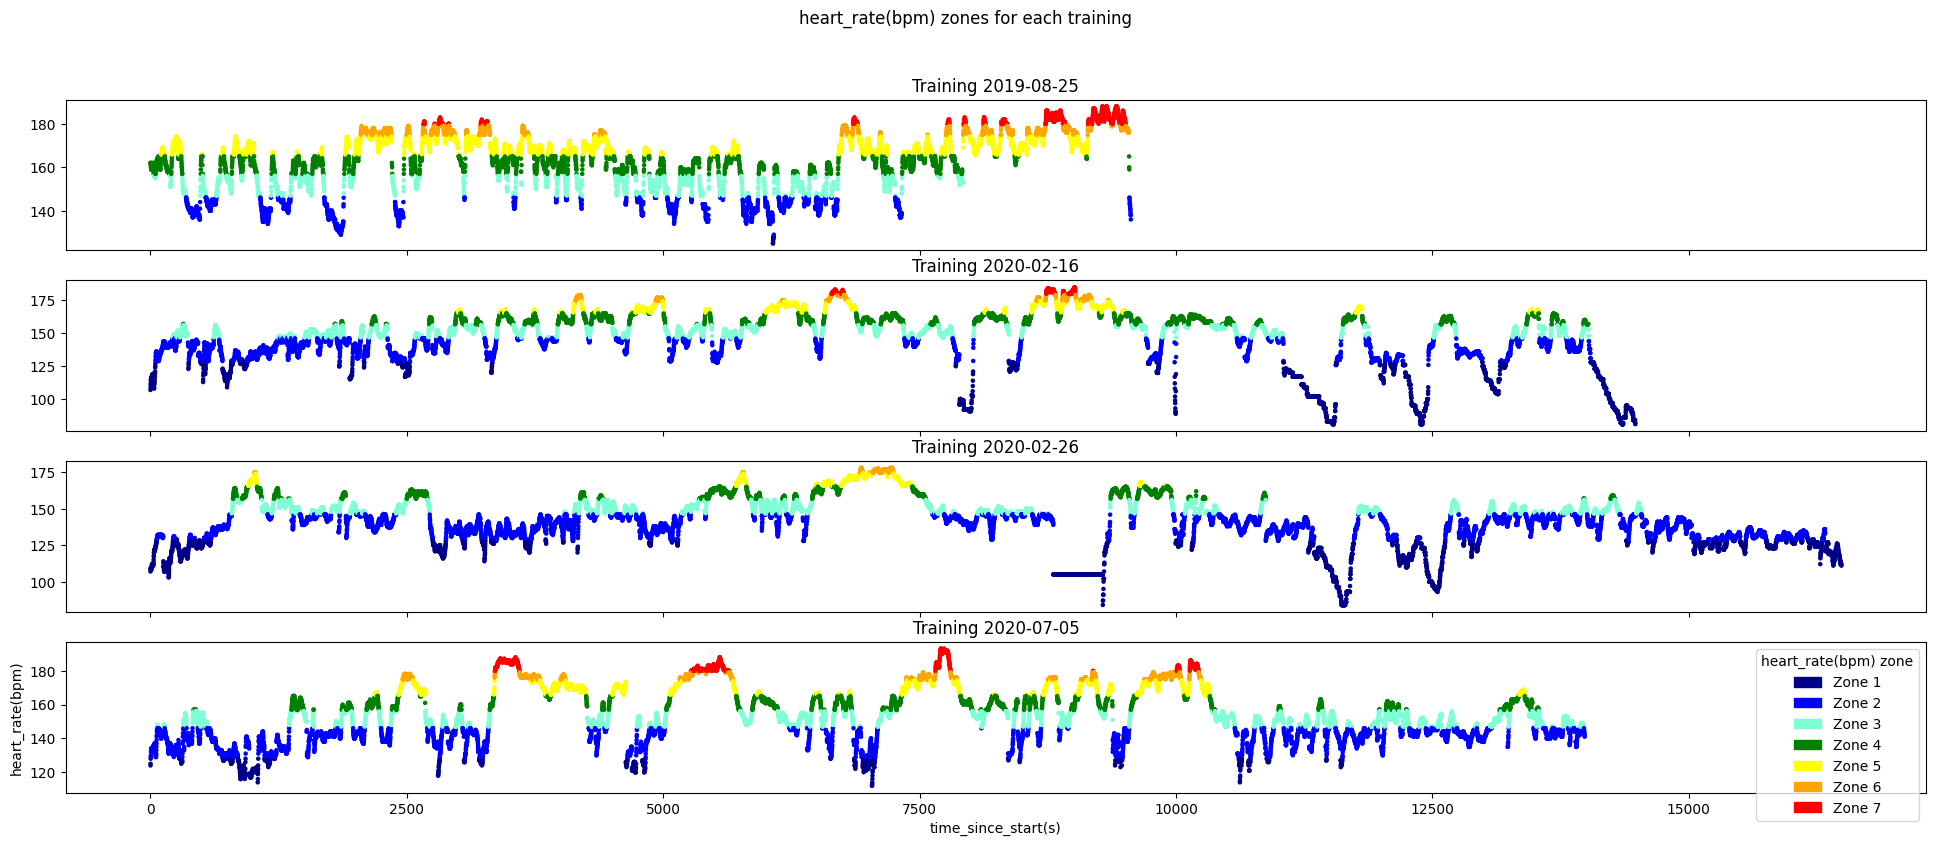

In [62]:
plot_scatter_zones_per_training('heart_rate(bpm)', 'hr_zone')

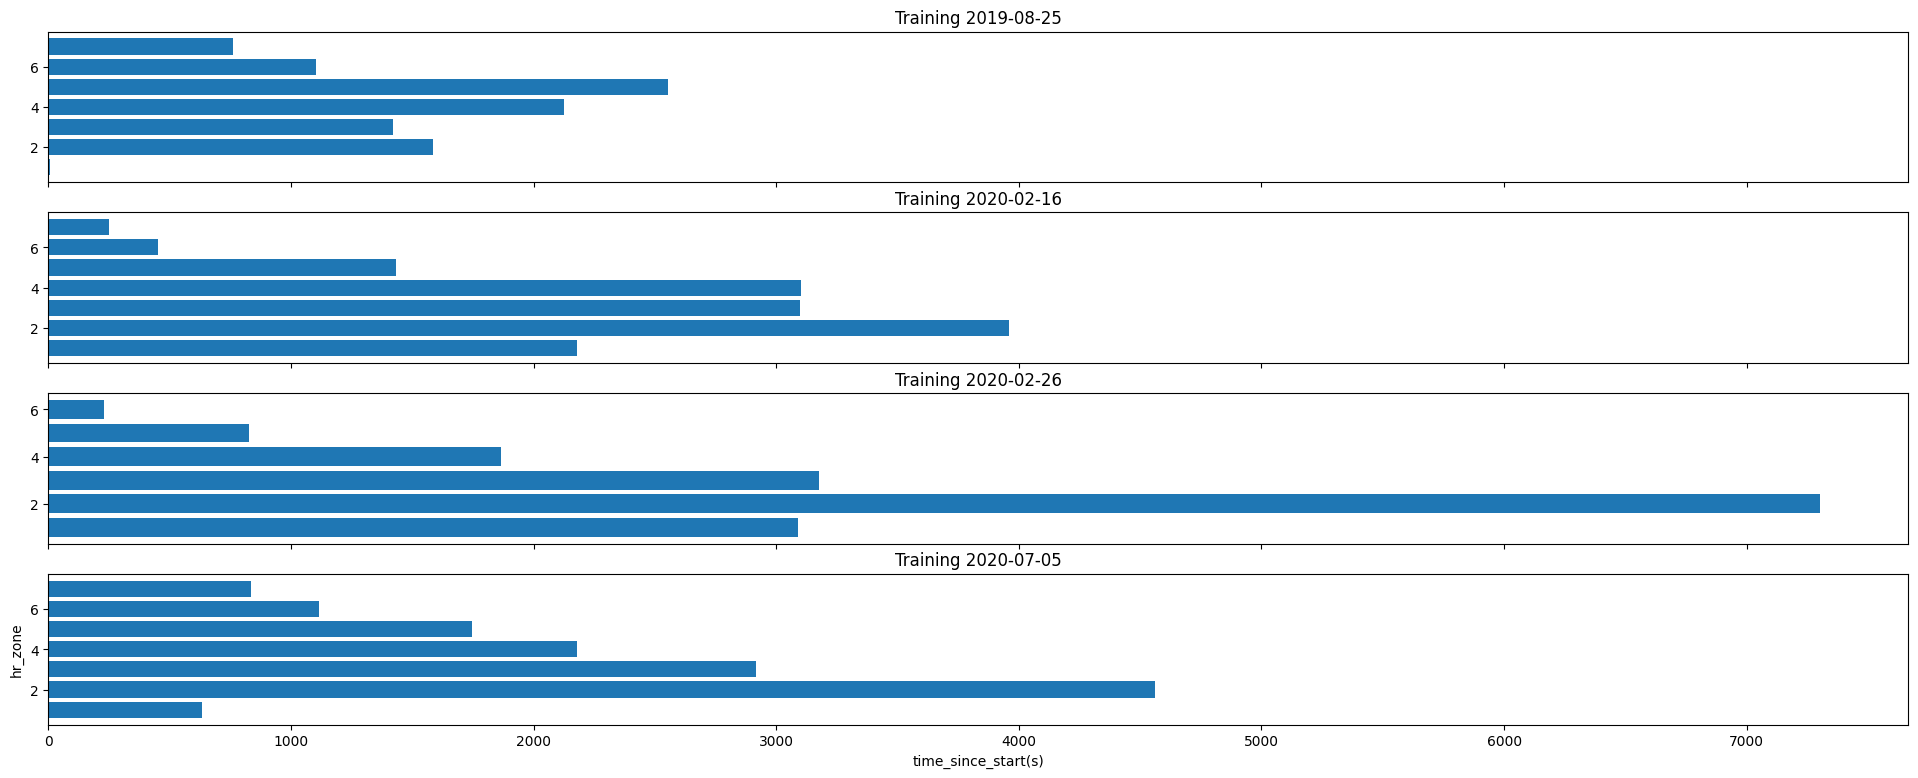

In [63]:
plot_zones_bars_per_training('hr_zone')

|--- time_since_start(s) <= 10578.00
|   |--- heart_rate(bpm) <= 146.50
|   |   |--- heart_rate(bpm) <= 128.50
|   |   |   |--- class: 1
|   |   |--- heart_rate(bpm) >  128.50
|   |   |   |--- class: 2
|   |--- heart_rate(bpm) >  146.50
|   |   |--- time_since_start(s) <= 2009.50
|   |   |   |--- heart_rate(bpm) <= 156.50
|   |   |   |   |--- class: 3
|   |   |   |--- heart_rate(bpm) >  156.50
|   |   |   |   |--- heart_rate(bpm) <= 165.50
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- heart_rate(bpm) >  165.50
|   |   |   |   |   |--- heart_rate(bpm) <= 174.50
|   |   |   |   |   |   |--- class: 5
|   |   |   |   |   |--- heart_rate(bpm) >  174.50
|   |   |   |   |   |   |--- class: 6
|   |   |--- time_since_start(s) >  2009.50
|   |   |   |--- heart_rate(bpm) <= 156.50
|   |   |   |   |--- class: 3
|   |   |   |--- heart_rate(bpm) >  156.50
|   |   |   |   |--- time_since_start(s) <= 9395.50
|   |   |   |   |   |--- time_since_start(s) <= 8638.50
|   |   |   |   |   |   |--- 

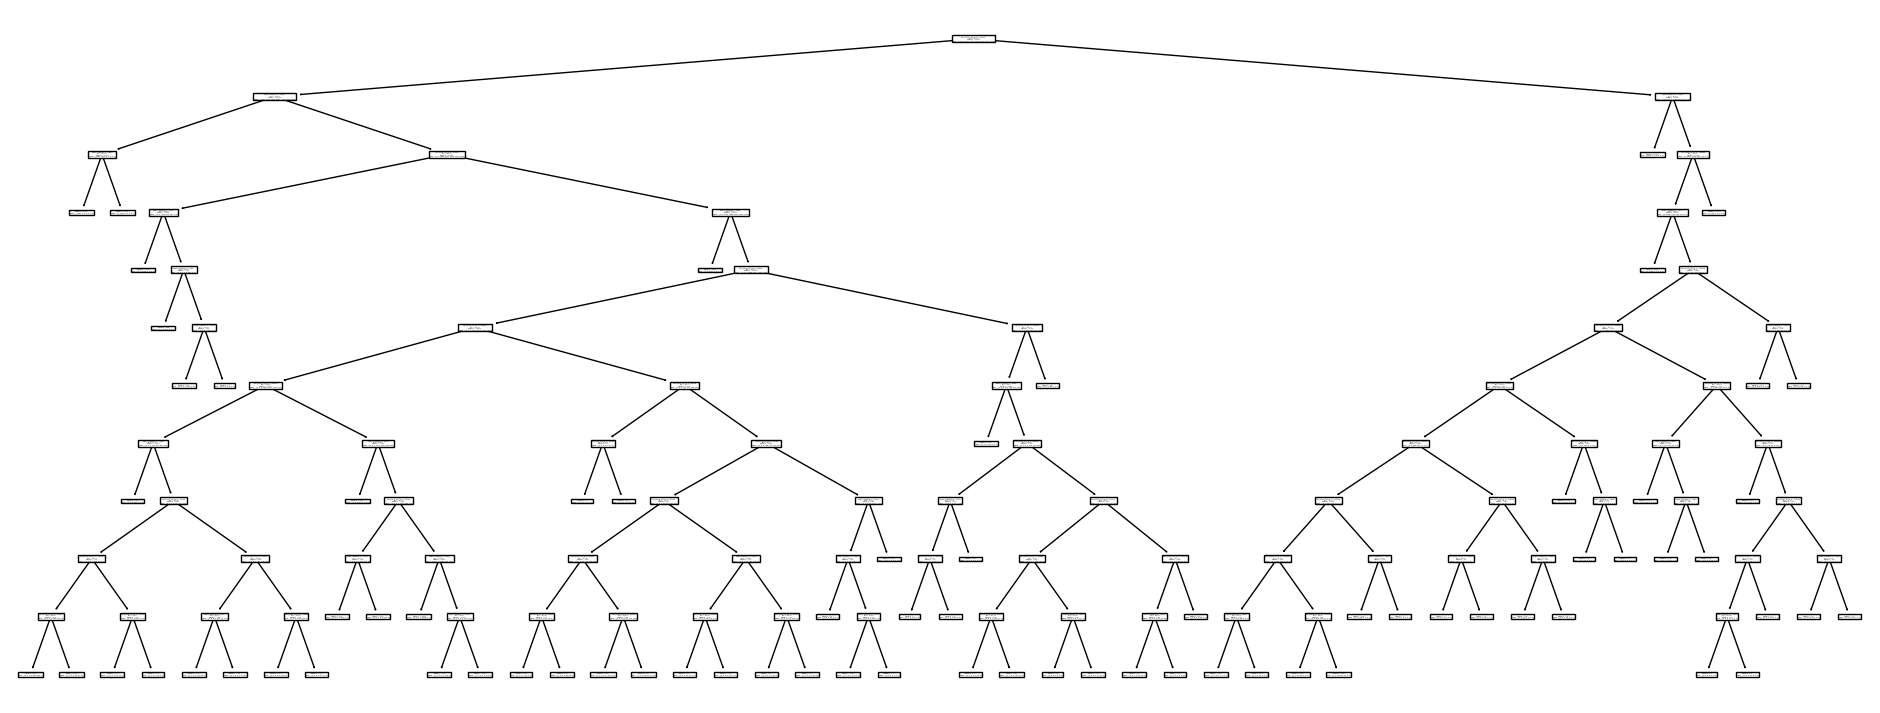

In [64]:
pipe = Pipeline([
    ("std", None),
    ("regressor", DecisionTreeClassifier())
])

grid = {
    "std": [StandardScaler(), None],
    "regressor__criterion": ["gini", "entropy", "log_loss"],
    "regressor__max_depth": [3, 5, 7, 9, 11],
    "regressor__splitter": ["best", "random"],
    "regressor__min_samples_leaf": [1, 2, 3, 4, 5],
    "regressor__min_samples_split": [2, 4, 6, 8, 10],
    "regressor__max_features": ["auto", "sqrt", "log2"]
}


model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=-1)
model.fit(X_train, y_train)

plt.figure(figsize=(24, 9))
plot_tree(model.best_estimator_["regressor"], feature_names=X_train.columns.to_list())
print(export_text(model.best_estimator_["regressor"], feature_names=X_train.columns.to_list()))

In [65]:
model_res = pd.DataFrame(model.cv_results_).sort_values("mean_test_score", ascending=False)

In [66]:
from sklearn.neural_network import MLPClassifier

pipe = Pipeline([
    ("std", StandardScaler()),
    ("regressor", MLPClassifier())
])

grid = {
    "regressor__hidden_layer_sizes": [(256, 256)],
    "regressor__activation": ["relu"],
    "regressor__max_iter": [2000],
    "regressor__batch_size": [128],
    "regressor__alpha": [0.01]

}

model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=-1)
model.fit(X_train, y_train)
print_eval(X_test, y_test, model)


   Mean squared error:          0.0
       Relative error:     0.00000%
R-squared coefficient:          1.0


In [67]:
neural_res = pd.DataFrame(model.cv_results_).sort_values("mean_test_score", ascending=False)

### Confronto fra modelli

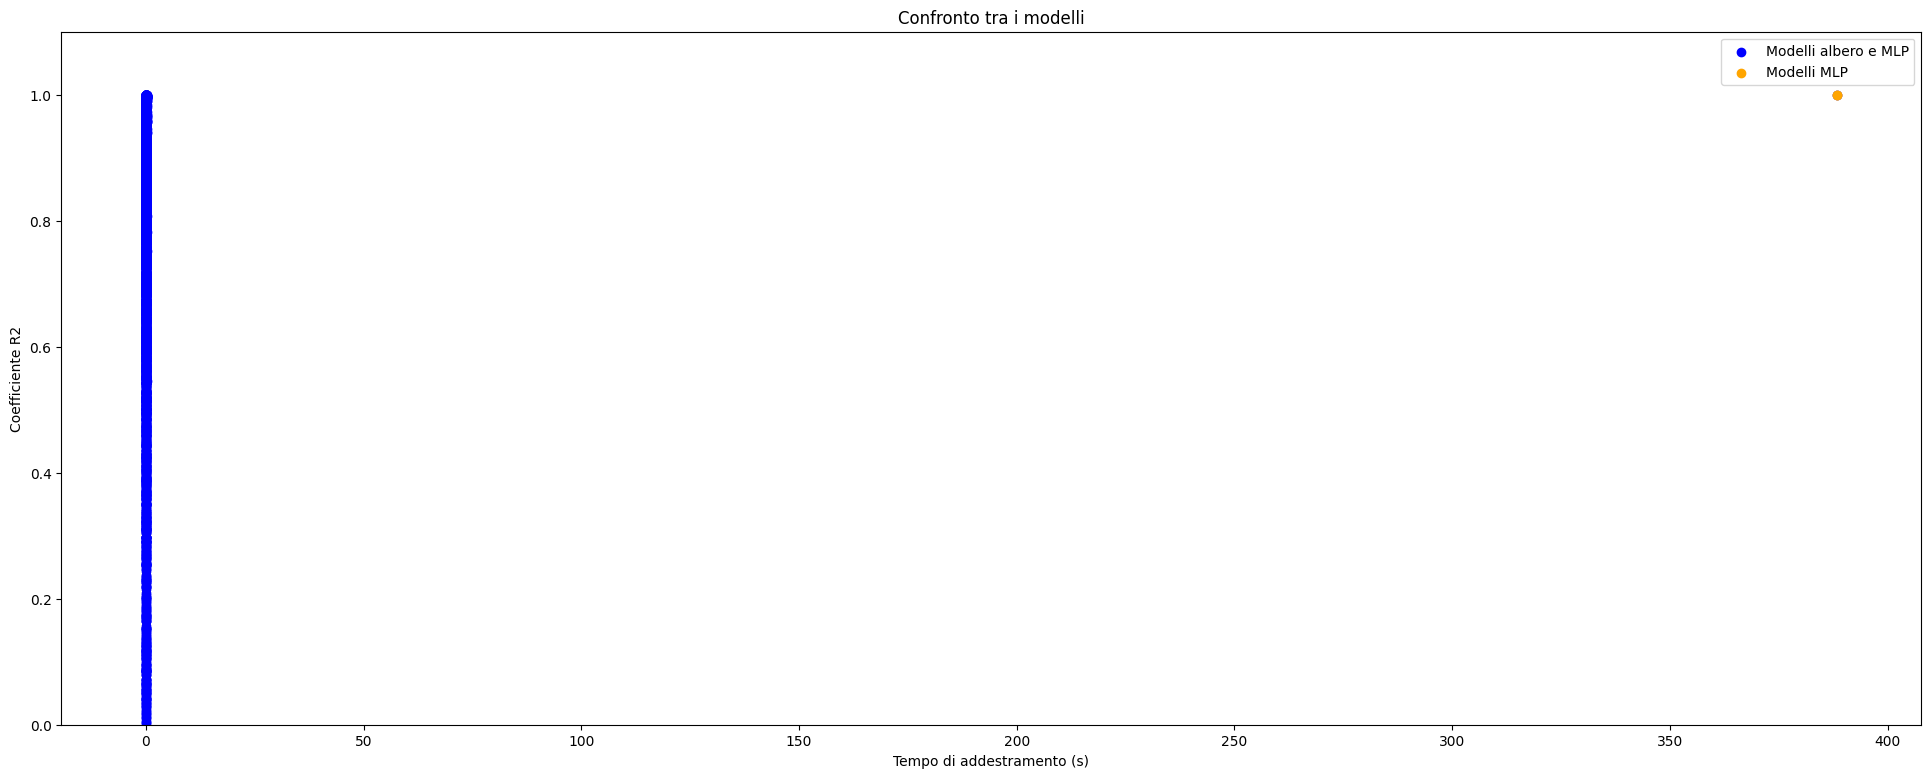

In [68]:
fig, ax = plt.subplots(figsize=(24, 9))

model_res = pd.concat([model_res, neural_res], axis=0)
scatter = ax.scatter(model_res['mean_fit_time'], model_res['mean_test_score'], color='blue', label='Modelli albero e MLP')

neural_res = pd.concat([neural_res, neural_res], axis=0)
scatter = ax.scatter(neural_res['mean_fit_time'], neural_res['mean_test_score'], color='orange', label='Modelli MLP')

ax.set_xlabel('Tempo di addestramento (s)')
ax.set_ylabel('Coefficiente R2')
ax.set_title('Confronto tra i modelli')
ax.legend()
plt.ylim(0, 1.1)
plt.show()

# Flask

Di seguito è riportato il codice di generazione di uno script python (*garmin_flask.py*) generante un file html che consente di immettere i dati di un allenamento e di ottenere la previsione del battito e della potenza a partire dai modelli migliori.

In [69]:
import os
import pickle
import flask

Il primo passo è generare dei folder su cui salvare i file necessari per la generazione del file html. In particolare vengono generati i seguenti folder:
- `templates`: contiene il file html generato
- `models`: contiene i modelli utilizzati per la previsione
- `datasets`: contiene i dataset utilizzati per la previsione

In [70]:
if not os.path.isdir("templates"):
  os.mkdir("templates")

if not os.path.isdir("models"):
  os.mkdir("models")

if not os.path.isdir("datasets"):
  os.mkdir("datasets")

Tramite `pickle` vengono salvati i modelli migliori per la previsione del battito e della potenza. Come visto sopra, i modelli migliori in entrambi i casi sono gli alberi di regressione.
In particolare
- per la previsione del battito (indica i parametri)
- per la previsione della potenza (indica i parametri)

In [71]:
with open("models/hr_model.bin", "wb") as f:
    pickle.dump(tree_gs.best_estimator_, f)

with open("models/watt_model.bin", "wb") as f:
    pickle.dump(watt_tree_gs.best_estimator_, f)

with open("datasets/hr_dataset.pkl", "wb") as f:
    pickle.dump(X_hr, f)

with open("datasets/watt_dataset.pkl", "wb") as f:
    pickle.dump(X_watt, f)

Da qui si comincia a scrivere sul file `garmin_flask.py`, importando le librerie necessarie al suo corretto funzionamento.

In [72]:
%%writefile garmin_flask.py
import os.path
import pickle
from flask import Flask, request, render_template
import numpy as np

Overwriting garmin_flask.py


Con l'attributo `-a` (append) di `%%writefile` è possibile aggiungere codice al file senza sovrascriverlo.

In [73]:
%%writefile -a garmin_flask.py

app = Flask(__name__)
app.debug = True

Appending to garmin_flask.py


In questa parte è definita la logica con cui rispondere alle richieste POST dell'utente dalla pagina HTML. In particolare, dopo aver deserializzato i dataset, se viene inviata una richiesta dalla card `hr` (corrispondente alla previsione del battito), si esegue quanto segue:
- si estraggono i dati inseriti dall'utente
  - a tal proposito occorre fare un cast a tipo int64 o float64 in base al tipo dichiarato nel dataset
- si inseriscono in una lista `inputs`
- si predice il battito corrispondente ai dati inseriti
  - occorre fare un reshape dei dati inseriti per poterli dare in pasto al modello

Completate queste operazioni si ricarica la pagina passandole il dato predetto `response`, la pagina si occuperà di inserirlo nel campo corrispondente.

In [74]:
%%writefile -a garmin_flask.py

@app.route("/", methods=["GET", "POST"])
def index():
    
    with open('datasets/hr_dataset.pkl', 'rb') as f:
        X_hr = pickle.load(f)
    with open('datasets/watt_dataset.pkl', 'rb') as f:
        X_watt = pickle.load(f)

    if request.method == "POST":
        card = request.form.get("card")

        if card == "hr":
            inputs = []
            for column_name, dtype in X_hr.dtypes.items():
                if dtype == "int64":
                    value = int(request.form[column_name])
                elif dtype == "float64":
                    value = float(request.form[column_name])
                inputs.append(value)
            with app.open_resource("models/hr_model.bin", "rb") as f:
                hr_model = pickle.load(f)
            response = hr_model.predict(np.array(inputs).reshape(1, -1))[0]
            return render_template("index.html", hr_pred=response, X_hr=X_hr, X_watt=X_watt)

        elif card == "watt":
            inputs = []
            for column_name, dtype in X_watt.dtypes.items():
                if dtype == "int64":
                    value = int(request.form[column_name])
                elif dtype == "float64":
                    value = float(request.form[column_name])
                inputs.append(value)
            with app.open_resource("models/watt_model.bin", "rb") as f:
                watt_model = pickle.load(f)
            response = watt_model.predict(np.array(inputs).reshape(1, -1))[0]
            return render_template("index.html", w_pred=response, X_hr=X_hr, X_watt=X_watt)

    return render_template("index.html", X_hr=X_hr, X_watt=X_watt)

Appending to garmin_flask.py


In [75]:
%%writefile -a garmin_flask.py

if __name__ == '__main__':
  app.run()

Appending to garmin_flask.py


Di seguito è riportata la pagina HTML che consente di inserire i dati e di ottenere la previsione del battito e della potenza.
Questa viene salvata all'interno di `templates/index.html`.

In [76]:
%%writefile templates/index.html

<!doctype html>
<html lang="en">

<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>Bootstrap demo</title>
  <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css" rel="stylesheet"
    integrity="sha384-9ndCyUaIbzAi2FUVXJi0CjmCapSmO7SnpJef0486qhLnuZ2cdeRhO02iuK6FUUVM" crossorigin="anonymous">
</head>

<body class="d-flex flex-column vh-100" data-bs-theme="dark">
  <header class="d-flex justify-content-center shadow py-3">
      <h1>data intensive</h1>
  </header>
  <div class="d-flex align-items-center justify-content-center h-100">
    <div class="card m-auto">
      <div class="card-body">
        <h5 class="card-title">Previsione battiti</h5>
        <form method="POST" action="">
          {% for column in X_hr.columns %}
          <div class="mb-3">
            <label for="{{ column }}" class="form-label">{{ column }}</label>
            <input name="{{ column }}" class="form-control" id="{{ column }}">
          </div>
          {% endfor %}
          <input type="hidden" name="card" value="hr">
          <button type="submit" class="btn btn-primary">Submit</button>
        </form>
      </div>
      <div class="card-footer">
        <p>Risultato: <b>{{ hr_pred }}</b></p>
      </div>
    </div>
    <div class="card m-auto">
      <div class="card-body">
        <h5 class="card-title">Previsione potenza</h5>
        <form method="POST" action="">
          {% for column in X_watt.columns %}
          <div class="mb-3">
            <label for="{{ column }}" class="form-label">{{ column }}</label>
            <input name="{{ column }}" class="form-control" id="{{ column }}">
          </div>
          {% endfor %}
          <input type="hidden" name="card" value="watt">
          <button type="submit" class="btn btn-primary">Submit</button>
        </form>
      </div>
      <div class="card-footer">
        <p>Risultato: <b>{{ w_pred }}</b></p>
      </div>
    </div>
  </div>
</body>

</html>


Overwriting templates/index.html
